In [2]:
import pandas as pd
import numpy as np
import datetime
import warnings
import seaborn as sns
from prophet import Prophet
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from plotly.subplots import make_subplots
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

### Load the dataset

In [3]:
#reading the dataset
df = pd.read_csv("files/Agrofood_co2_emission.csv")
df

Area  Year  Savanna fires  Forest fires  Crop Residues  \
0     Afghanistan  1990        14.7237        0.0557       205.6077   
1     Afghanistan  1991        14.7237        0.0557       209.4971   
2     Afghanistan  1992        14.7237        0.0557       196.5341   
3     Afghanistan  1993        14.7237        0.0557       230.8175   
4     Afghanistan  1994        14.7237        0.0557       242.0494   
...           ...   ...            ...           ...            ...   
6960     Zimbabwe  2016      1190.0089      232.5068        70.9451   
6961     Zimbabwe  2017      1431.1407      131.1324       108.6262   
6962     Zimbabwe  2018      1557.5830      221.6222       109.9835   
6963     Zimbabwe  2019      1591.6049      171.0262        45.4574   
6964     Zimbabwe  2020       481.9027       48.4197       108.3022   

      Rice Cultivation  Drained organic soils (CO2)  Pesticides Manufacturing  \
0             686.0000                          0.0                 11.807483   
1             678.1600                          0.0                 11.712073   
2             686.0000                          0.0                 11.712073   
3             686.0000                          0.0                 11.712073   
4             705.6000                          0.0                 11.712073   
...                ...                          ...                       ...   
6960            7.4088                          0.0                 75.000000   
6961            7.9458                          0.0                 67.000000   
6962            8.1399                          0.0                 66.000000   
6963            7.8322                          0.0                 73.000000   
6964            7.9733                          0.0                 73.000000   

      Food Transport  Forestland  Net Forest conversion  \
0            63.1152  -2388.8030                 0.0000   
1            61.2125  -2388.8030                 0.0000   
2            53.3170  -2388.8030                 0.0000   
3            54.3617  -2388.8030                 0.0000   
4            53.9874  -2388.8030                 0.0000   
...              ...         ...                    ...   
6960        251.1465  76500.2982             10662.4408   
6961        255.7975  76500.2982             10662.4408   
6962        327.0897  76500.2982             10662.4408   
6963        290.1893  76500.2982             10662.4408   
6964        238.7639  76500.2982             10662.4408   

      Food Household Consumption  Food Retail  On-farm Electricity Use  \
0                        79.0851     109.6446                  14.2666   
1                        80.4885     116.6789                  11.4182   
2                        80.7692     126.1721                   9.2752   
3                        85.0678      81.4607                   9.0635   
4                        88.8058      90.4008                   8.3962   
...                          ...          ...                      ...   
6960                    251.2681     443.0872                 428.4352   
6961                    203.1236     445.3881                 304.7852   
6962                    211.1539     492.8599                 346.8512   
6963                    228.6381     542.5922                 350.2168   
6964                    213.9211     568.0445                 350.2168   

      Food Packaging  Agrifood Systems Waste Disposal  Food Processing  \
0          67.631366                         691.7888        252.21419   
1          67.631366                         710.8212        252.21419   
2          67.631366                         743.6751        252.21419   
3          67.631366                         791.9246        252.21419   
4          67.631366                         831.9181        252.21419   
...              ...                              ...              ...   
6960       22.910800                        1077.2392        317.07440 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Area                             6965 non-null   object 
 1   Year                             6965 non-null   int64  
 2   Savanna fires                    6934 non-null   float64
 3   Forest fires                     6872 non-null   float64
 4   Crop Residues                    5576 non-null   float64
 5   Rice Cultivation                 6965 non-null   float64
 6   Drained organic soils (CO2)      6965 non-null   float64
 7   Pesticides Manufacturing         6965 non-null   float64
 8   Food Transport                   6965 non-null   float64
 9   Forestland                       6472 non-null   float64
 10  Net Forest conversion            6472 non-null   float64
 11  Food Household Consumption       6492 non-null   float64
 12  Food Retail         

In [5]:
df.groupby('Area').CLIENTCODE.nunique()

AttributeError: 'DataFrameGroupBy' object has no attribute 'CLIENTCODE'

In [4]:
df.describe()

Year  Savanna fires  Forest fires  Crop Residues  \
count  6965.000000    6934.000000   6872.000000    5576.000000   
mean   2005.124910    1188.390893    919.302167     998.706309   
std       8.894665    5246.287783   3720.078752    3700.345330   
min    1990.000000       0.000000      0.000000       0.000200   
25%    1997.000000       0.000000      0.000000      11.006525   
50%    2005.000000       1.651850      0.517900     103.698200   
75%    2013.000000     111.081400     64.950775     377.640975   
max    2020.000000  114616.401100  52227.630600   33490.074100   

       Rice Cultivation  Drained organic soils (CO2)  \
count       6965.000000                  6965.000000   
mean        4259.666673                  3503.228636   
std        17613.825187                 15861.445678   
min            0.000000                     0.000000   
25%          181.260800                     0.000000   
50%          534.817400                     0.000000   
75%         1536.640000                   690.408800   
max       164915.255600                241025.069600   

       Pesticides Manufacturing  Food Transport     Forestland  \
count               6965.000000     6965.000000    6472.000000   
mean                 333.418393     1939.581760  -17828.285678   
std                 1429.159367     5616.748808   81832.210543   
min                    0.000000        0.000100 -797183.079000   
25%                    6.000000       27.958600   -2848.350000   
50%                   13.000000      204.962800     -62.920000   
75%                  116.325487     1207.000900       0.000000   
max                16459.000000    67945.765000  171121.076000   

       Net Forest conversion  Food Household Consumption    Food Retail  \
count           6.472000e+03                 6492.000000    6965.000000   
mean            1.760564e+04                 4847.580384    2043.210539   
std             1.011575e+05                25789.143619    8494.249260   
min             0.000000e+00                    0.000000       0.000000   
25%             0.000000e+00                   11.399950      26.818500   
50%             4.444000e+01                  155.471100     172.042600   
75%             4.701746e+03                 1377.151950    1075.999100   
max             1.605106e+06               466288.200700  133784.065300   

       On-farm Electricity Use  Food Packaging  \
count              6965.000000     6965.000000   
mean               1626.681460     1658.629808   
std                9343.182193    11481.343725   
min                   0.000000        0.000000   
25%                   8.037600       67.631366   
50%                  29.120700       74.018133   
75%                 499.944700      281.791000   
max              165676.299000   175741.306100   

       Agrifood Systems Waste Disposal  Food Processing  \
count                      6965.000000      6965.000000   
mean                       6018.444633      3872.724461   
std                       22156.742542     19838.216846   
min                           0.340000         0.000100   
25%                          86.680500       209.587728   
50%                         901.275700       344.760200   
75%                        3006.442100      1236.913400   
max                      213289.701600    274253.512500   

       Fertilizers Manufacturing          IPPU  Manure applied to Soils  \
count                6965.000000  6.222000e+03              6037.000000   
mean                 3035.723356  1.999150e+04               923.225603   
std                 11693.029064  1.114209e+05              3226.992039   
min                     0.001900  0.000000e+00                 0.049000   
25%                   360.358799  3.903153e+01                16.303000   
50%                  1115.052400  8.037066e+02               120.443900   
75%                  2024.869900  6.155175e+03               460.120200   
max                170826.423300  1.861641e+06             3

### Data cleaning

In [5]:
df = df.drop_duplicates() # removing duplicated rows

##### Headers standardization, column name changes

In [6]:
df.columns = [col.lower().replace(' ','_') for col in df.columns] # standardizing headers

In [7]:
df.columns

Index(['area', 'year', 'savanna_fires', 'forest_fires', 'crop_residues',
       'rice_cultivation', 'drained_organic_soils_(co2)',
       'pesticides_manufacturing', 'food_transport', 'forestland',
       'net_forest_conversion', 'food_household_consumption', 'food_retail',
       'on-farm_electricity_use', 'food_packaging',
       'agrifood_systems_waste_disposal', 'food_processing',
       'fertilizers_manufacturing', 'ippu', 'manure_applied_to_soils',
       'manure_left_on_pasture', 'manure_management', 'fires_in_organic_soils',
       'fires_in_humid_tropical_forests', 'on-farm_energy_use',
       'rural_population', 'urban_population', 'total_population_-_male',
       'total_population_-_female', 'total_emission',
       'average_temperature_°c'],
      dtype='object')

In [8]:
df.rename(columns={"on-farm_energy_use": "on_farm_energy_use", "average_temperature_°c": "avg_temp_change"}, inplace=True) #changing the name of the column

##### Dealing with NaNs

In [9]:
df.isna().sum() #checking for NaNs

area                                  0
year                                  0
savanna_fires                        31
forest_fires                         93
crop_residues                      1389
rice_cultivation                      0
drained_organic_soils_(co2)           0
pesticides_manufacturing              0
food_transport                        0
forestland                          493
net_forest_conversion               493
food_household_consumption          473
food_retail                           0
on-farm_electricity_use               0
food_packaging                        0
agrifood_systems_waste_disposal       0
food_processing                       0
fertilizers_manufacturing             0
ippu                                743
manure_applied_to_soils             928
manure_left_on_pasture                0
manure_management                   928
fires_in_organic_soils                0
fires_in_humid_tropical_forests     155
on_farm_energy_use                  956


In [10]:
# For the columns which have >500 NaNs, I'll replace the missing values with the median. 
df["crop_residues"] = df["crop_residues"].fillna(df["crop_residues"].median())
df["ippu"] = df["ippu"].fillna(df["ippu"].median())
df["manure_applied_to_soils"] = df["manure_applied_to_soils"].fillna(df["manure_applied_to_soils"].median())
df["manure_management"] = df["manure_management"].fillna(df["manure_management"].median())
df["on_farm_energy_use"] = df["on_farm_energy_use"].fillna(df["on_farm_energy_use"].median())

# For the ones with lower NaN count, I will drop NaNs. 
df.dropna(inplace=True)

##### Standardizing categoricals

In [11]:
df["area"].value_counts()

Afghanistan              31
New Caledonia            31
Mexico                   31
Mongolia                 31
Morocco                  31
                         ..
Serbia and Montenegro     8
Czechoslovakia            3
USSR                      2
Yugoslav SFR              2
Ethiopia PDR              2
Name: area, Length: 202, dtype: int64

In [12]:
# Checking the areas with low value count (where we have less years of data)
area_counts = df["area"].value_counts()
low_areas = area_counts[area_counts < 20].index.tolist()
low_areas

['Serbia',
 'Montenegro',
 'Sudan',
 'South Sudan',
 'Serbia and Montenegro',
 'Czechoslovakia',
 'USSR',
 'Yugoslav SFR',
 'Ethiopia PDR']

In [13]:
# Creating a filter on low count areas and saving it as a dataset
mask = df['area'].isin(area_counts[area_counts >= 20].index)

df1 = df[mask]

In [14]:
# Saving a dataset with selected areas (6 with the highest CO2 emission)
area_selection = ["China", "United States of America", "Brazil", "India", "Indonesia", "Democratic Republic of the Congo"]

# Creating a copy of the dataset with filtering rows with the specified values in the "area" column
df_area_selection = df1[df1['area'].isin(area_selection)].copy()

### Exploratory Data Analysis

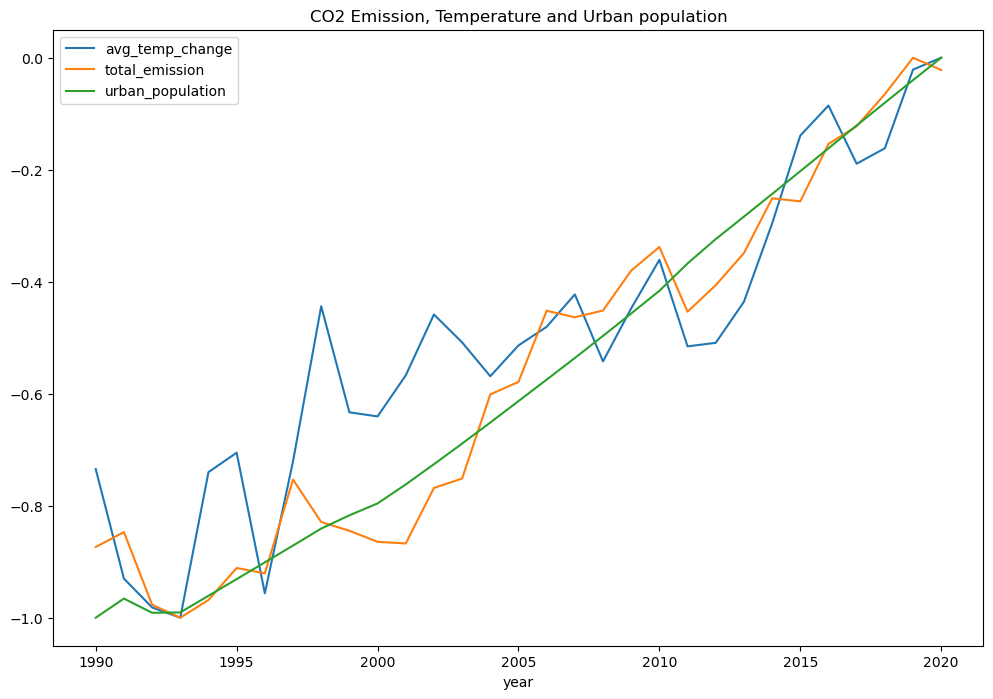

In [15]:
# Normalizing selected features (mean values) aggregated by year to compare them 
def normalizer(df):
    norm = (df - df.max()) / (df.max() - df.min())
    return norm

selected_means = df1.groupby("year").agg({"avg_temp_change": "mean", "total_emission": "mean", "urban_population": "mean"})
norm_means = normalizer(selected_means)

# Creating a plot to illustrate a growing trend for those 3 features
norm_means.plot(figsize=(12, 8))
plt.title("CO2 Emission, Temperature and Urban population")
plt.show()

In [16]:
numericals = df1.select_dtypes("number")
categoricals = df1.select_dtypes("object")

##### Probability distribution 

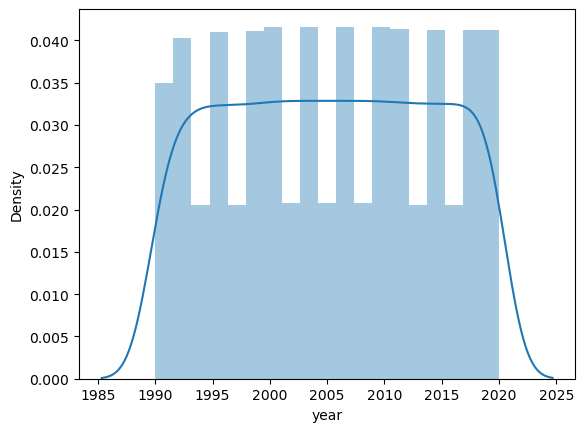

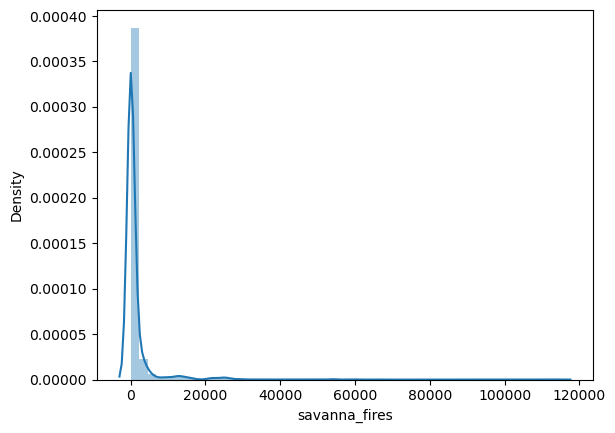

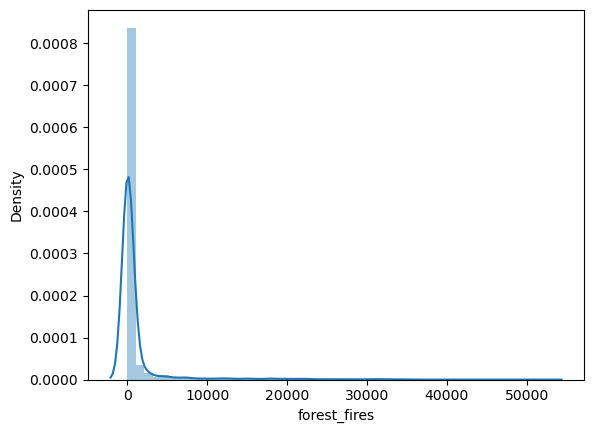

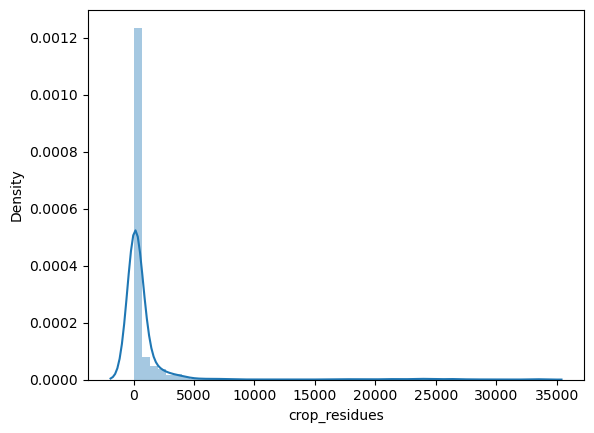

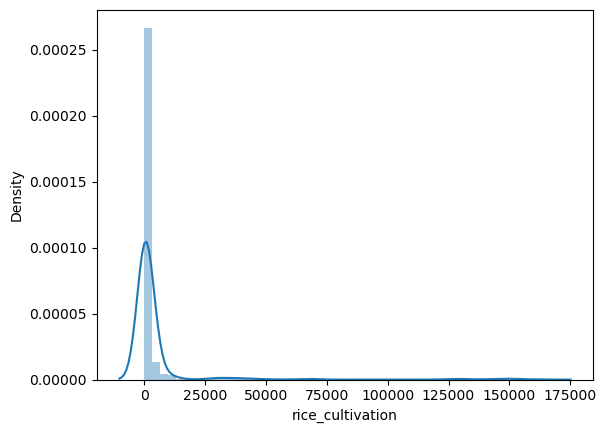

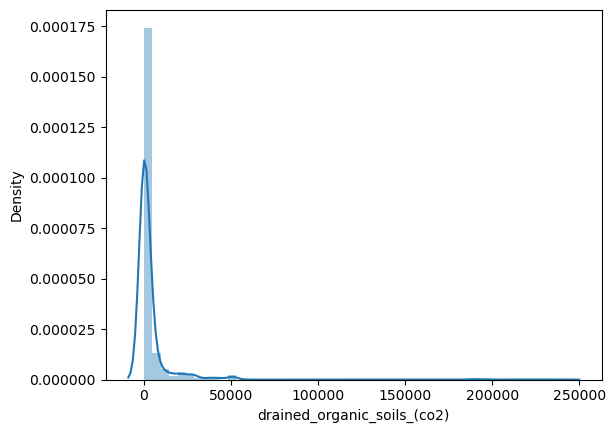

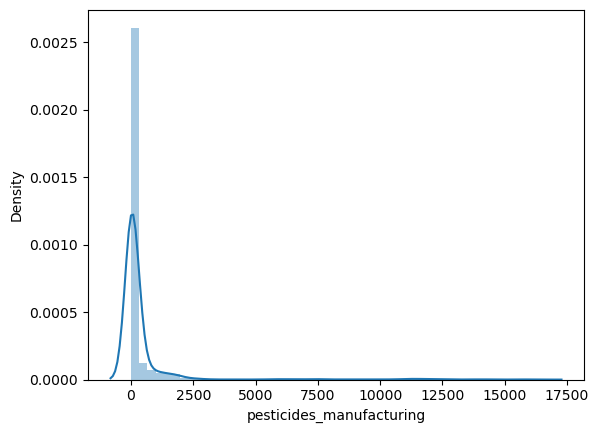

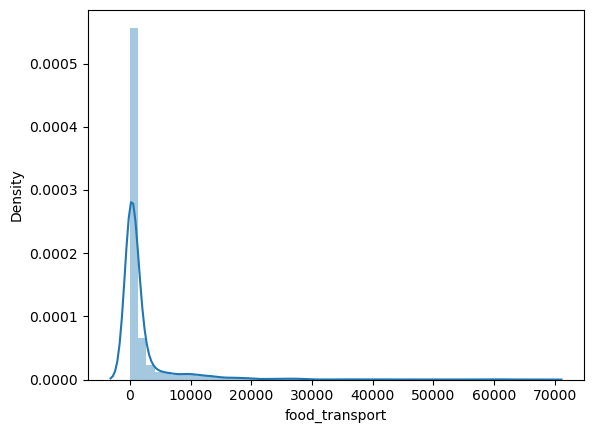

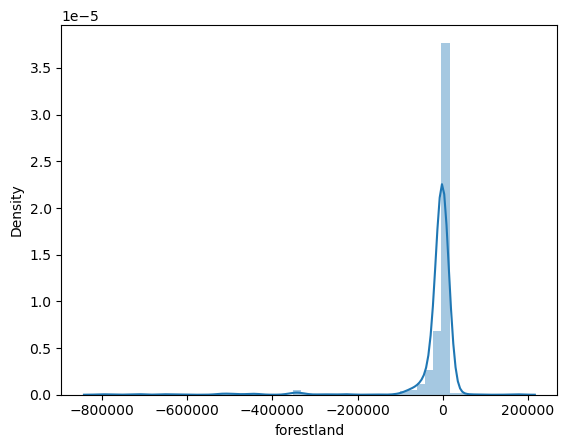

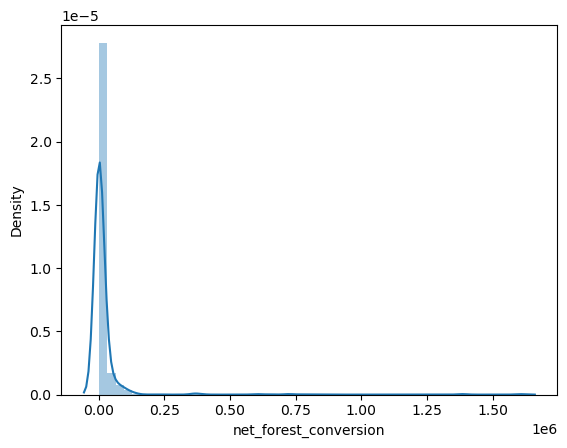

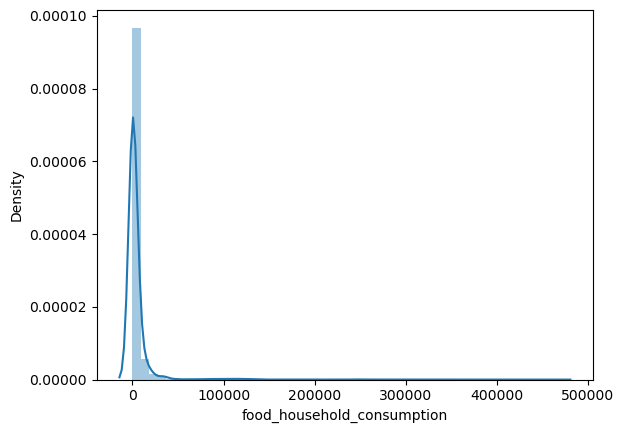

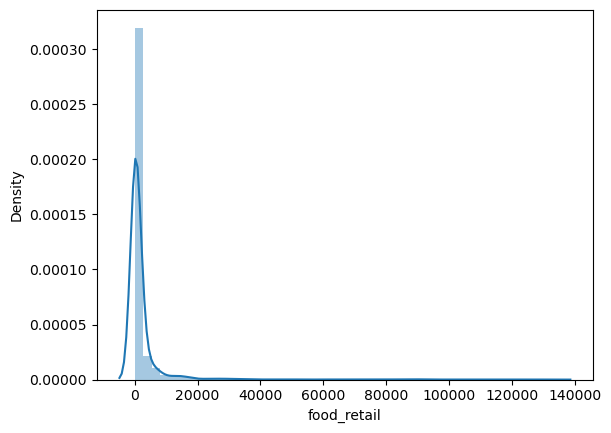

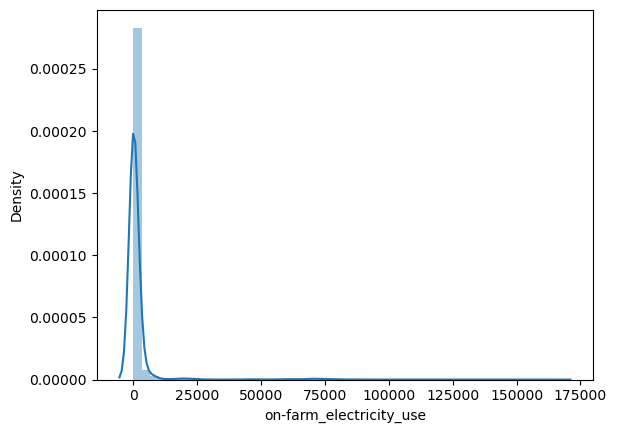

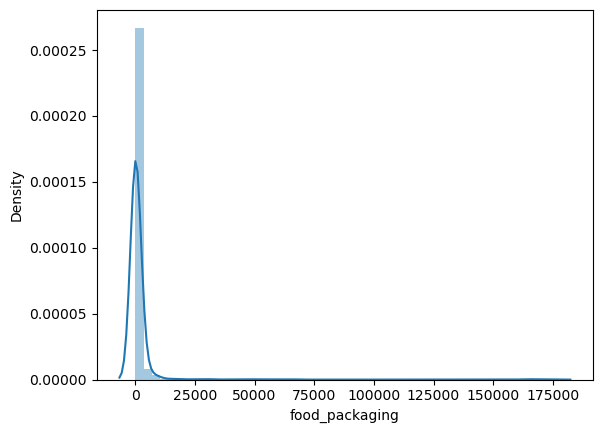

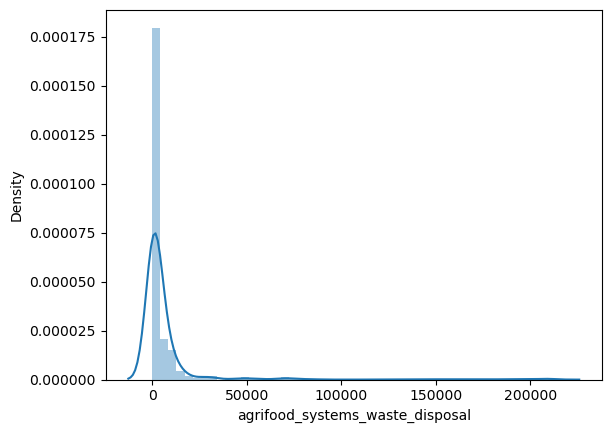

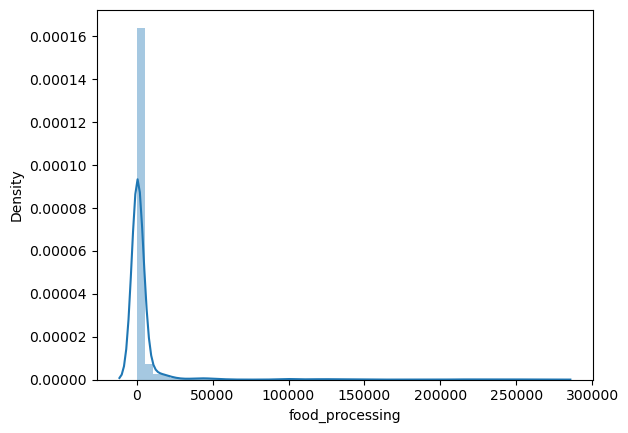

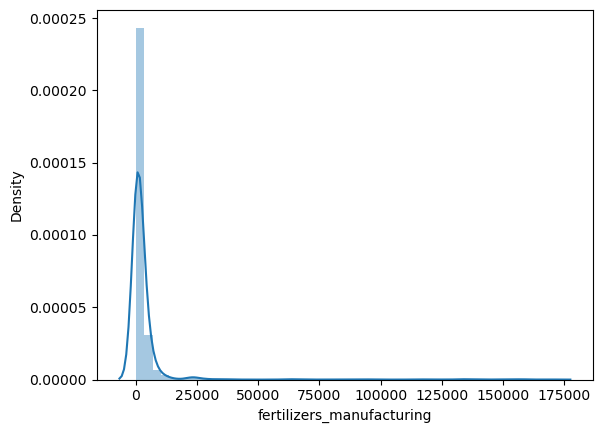

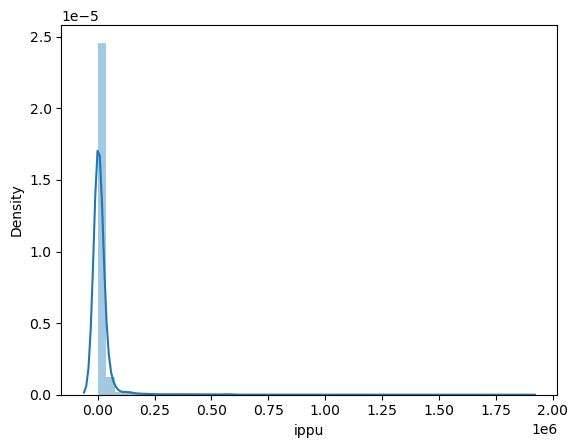

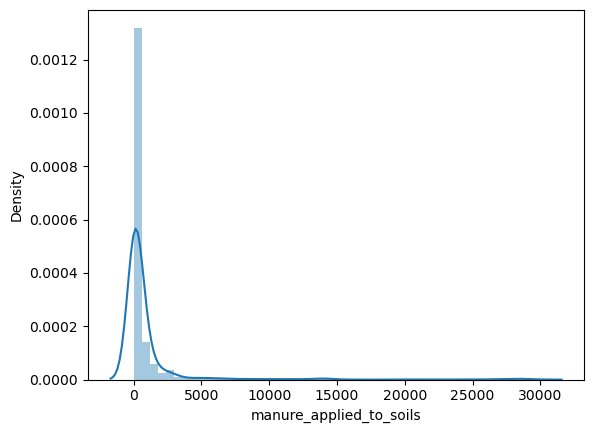

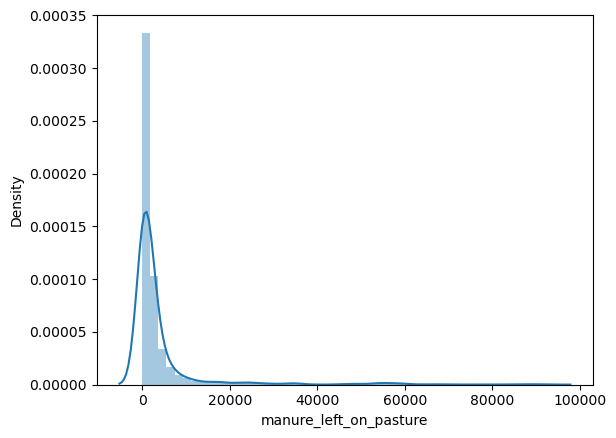

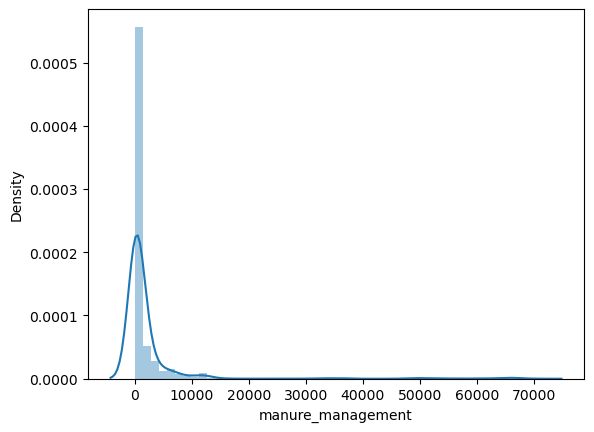

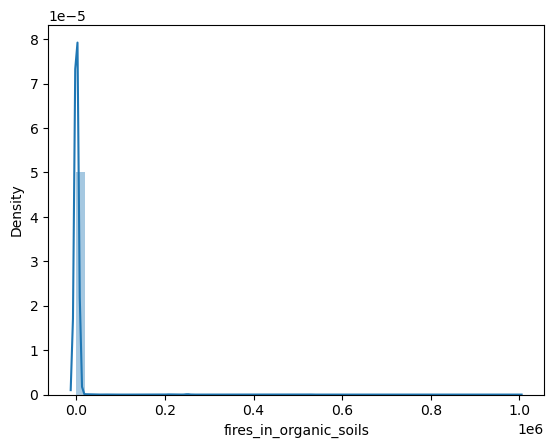

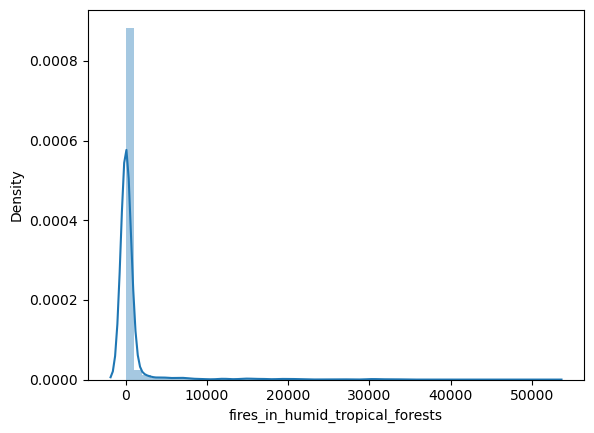

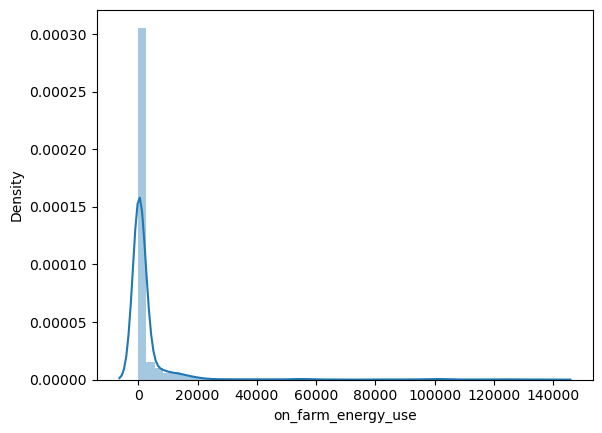

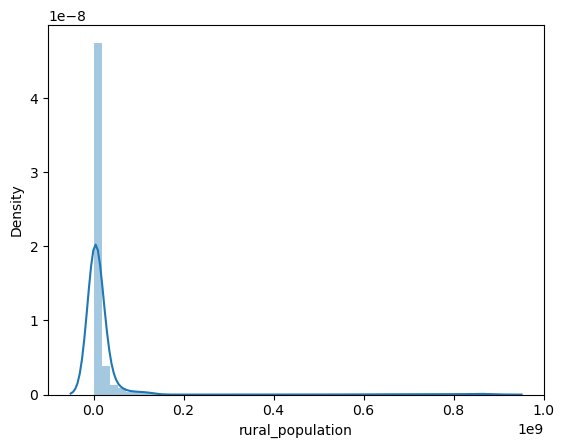

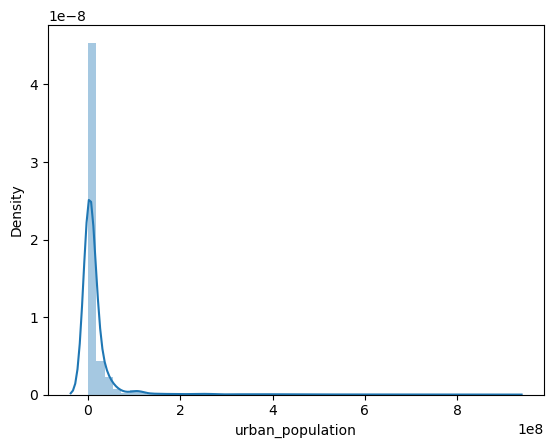

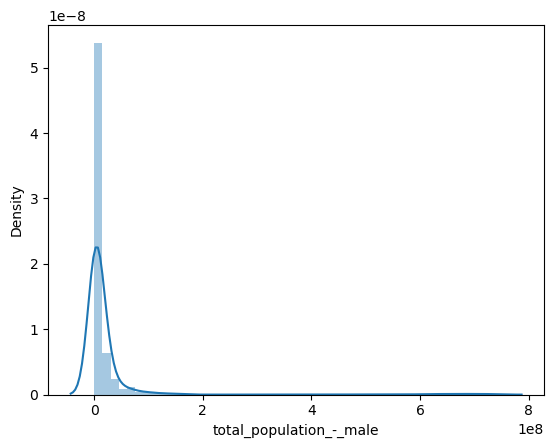

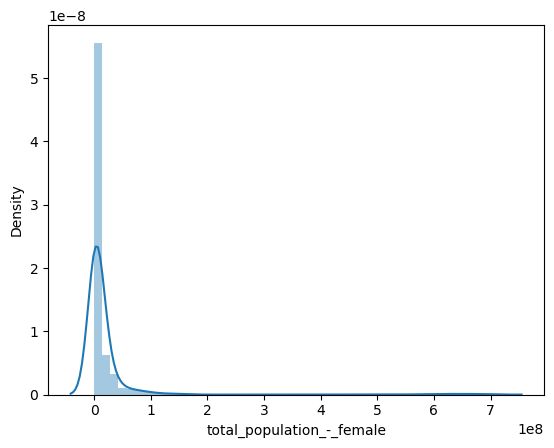

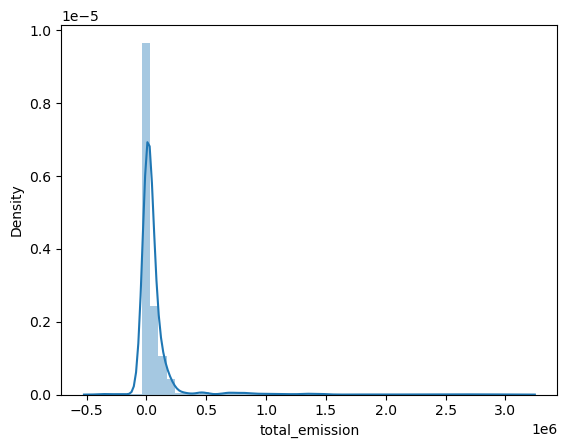

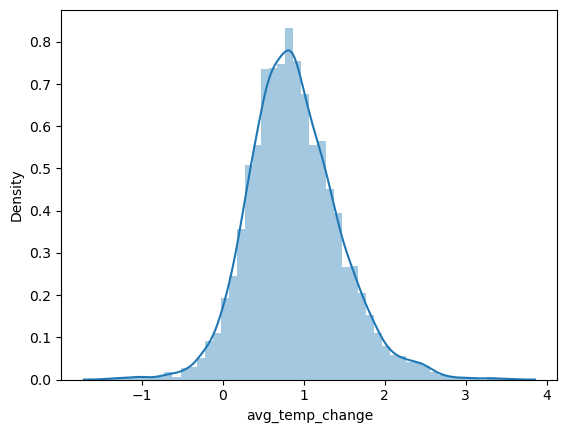

In [17]:
for col in numericals.columns:
    sns.distplot(numericals[col])
    plt.show()

# We are observing a normal distribution of features and target with a strong skew in most cases and a lot of 0 values (in case a certain type of activity isn't represented in the area). 

##### Outliers analysis

<Axes: >

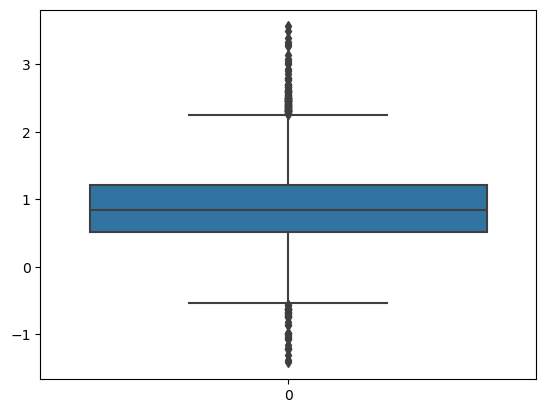

In [18]:
sns.boxplot(df1["avg_temp_change"])

In [19]:
# With average temperature change around +1, we still have (as expected) a lot of outliers in the dataset, with avg_temp_changing amongst the countries in a positive and negative way

# We can analyse them by calculating lower and upper boundary and using it to filter the dataset
IQR = abs(np.quantile(df1["avg_temp_change"], .25) - np.quantile(df1["avg_temp_change"], .75)) * 1.5
lower_boundary = np.quantile(df1["avg_temp_change"], .25) - IQR
upper_boundary = np.quantile(df1["avg_temp_change"], .75) + IQR
round(lower_boundary,4), round(upper_boundary,4)

(-0.5337, 2.2623)

In [20]:
df1[(df1["avg_temp_change"] > 2.2623) | (df1["avg_temp_change"] < -0.5337)].sort_values("avg_temp_change")

area  year  savanna_fires  forest_fires  crop_residues  \
2559           Greenland  1993         0.0784        0.0000       103.6982   
2558           Greenland  1992         0.0784        0.0000       103.6982   
279              Armenia  1992         4.3406        0.9319        25.8792   
2403             Georgia  1992         5.1179        6.0070        33.9665   
3054                Iraq  1992        81.3996       11.7017       263.5744   
...                  ...   ...            ...           ...            ...   
582              Belarus  2020        17.5912       28.2939       464.5580   
2278             Finland  2020         0.0000        0.0000       204.5646   
3510              Latvia  2020         0.0723        0.0000       215.1725   
2092             Estonia  2020         0.0788        0.0000        99.2221   
5261  Russian Federation  2020      5538.7853     3335.0838      8736.1337   

      rice_cultivation  drained_organic_soils_(co2)  pesticides_manufacturing  \
2559       1123.938232                       0.0000                 11.481085   
2558       1123.938232                       0.0000                 11.481085   
279         248.061497                       0.0000                  0.000000   
2403        248.061497                       0.0000                 61.000000   
3054        744.800000                       0.0000                 37.000000   
...                ...                          ...                       ...   
582         926.342278                   41960.7529                123.000000   
2278        622.051399                   13955.5700                 67.000000   
3510        611.020384                    5224.7552                 36.000000   
2092        306.050379                    5209.9951                 19.000000   
5261       1536.130400                   52839.6553               2225.000000   

      food_transport   forestland  net_forest_conversion  \
2559          7.0169      -0.1356                 0.0000   
2558          7.0483      -0.1356                 0.0000   
279          36.2934      76.3667                54.2254   
2403        123.1267  -18267.5508                 0.0000   
3054       2606.5052    -137.3753                 0.0000   
...              ...          ...                    ...   
582        1185.1021  -43554.3753                 0.0000   
2278        888.0250       0.0000                 0.0000   
3510        253.2426   -5710.5915               581.1366   
2092        209.4318    -574.0618                 0.0000   
5261      20165.7085 -622211.7411             34533.9490   

      food_household_consumption  food_retail  on-farm_electricity_use  \
2559                      7.6748       1.2093                   0.1840   
2558                      6.6055       1.1768                   0.1576   
279                     301.7828     101.2013                 592.5302   
2403                    822.8348     264.7503                 232.1913   
3054                    927.2753      51.5700                 806.3185   
...                          ...          ...                      ...   
582                    1174.7608     663.9411                 582.7215   
2278                    225.4920     958.0173                  67.5003   
3510                    122.0776     140.5778                  20.6827   
2092                    191.7941     338.2283                  93.0675   
5261                  62575.3972   13412.3594                7390.7148   

      food_packaging  agrifood_systems_waste_disposal  food_processing  \
2559        0.107800                           2.6900        22.377300   
2558        0.108400                           2.6788        22.377300   
279        20.131200                         280.6647        73.326300   
2403        3.958400                         347.8109         4.721800   
3054       80.090868                        6961.0397       296.287485   
...              ...                              ...   

##### Relationships between the features and the target

In [21]:
# Numerical features
correlations_matrix = numericals.corr()
correlations_matrix["avg_temp_change"].sort_values(ascending=False)

avg_temp_change                    1.000000
year                               0.547382
food_transport                     0.075187
food_retail                        0.074082
ippu                               0.064352
food_household_consumption         0.057497
food_processing                    0.054561
fertilizers_manufacturing          0.043686
food_packaging                     0.042374
manure_applied_to_soils            0.041900
on_farm_energy_use                 0.041350
urban_population                   0.035025
manure_management                  0.031337
drained_organic_soils_(co2)        0.027669
pesticides_manufacturing           0.025604
crop_residues                      0.023234
total_emission                     0.015874
on-farm_electricity_use            0.007525
agrifood_systems_waste_disposal    0.005009
total_population_-_female          0.001564
total_population_-_male           -0.000299
manure_left_on_pasture            -0.022804
rural_population                

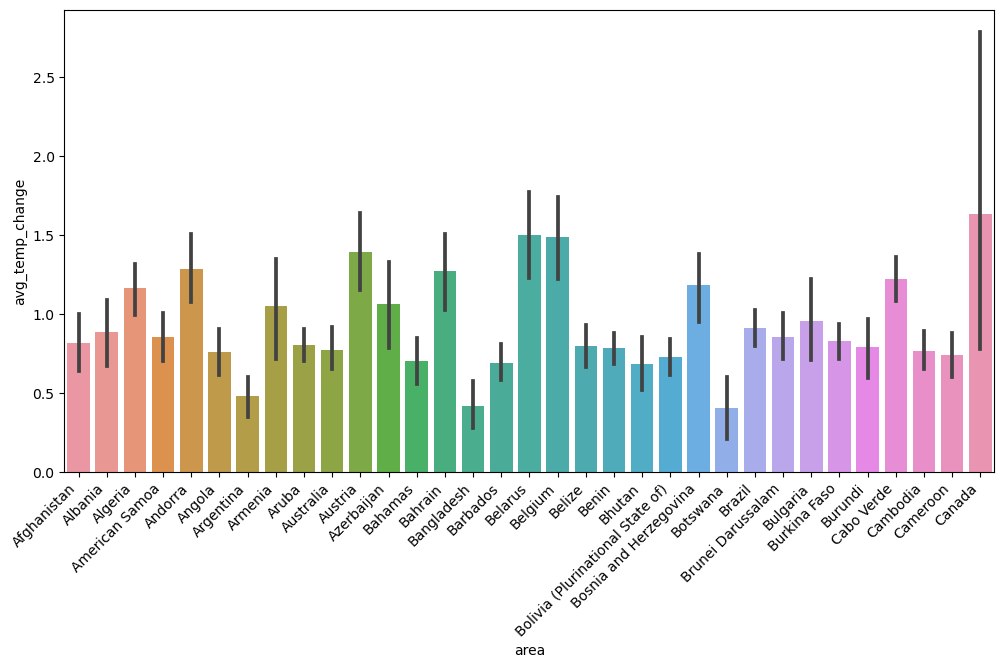

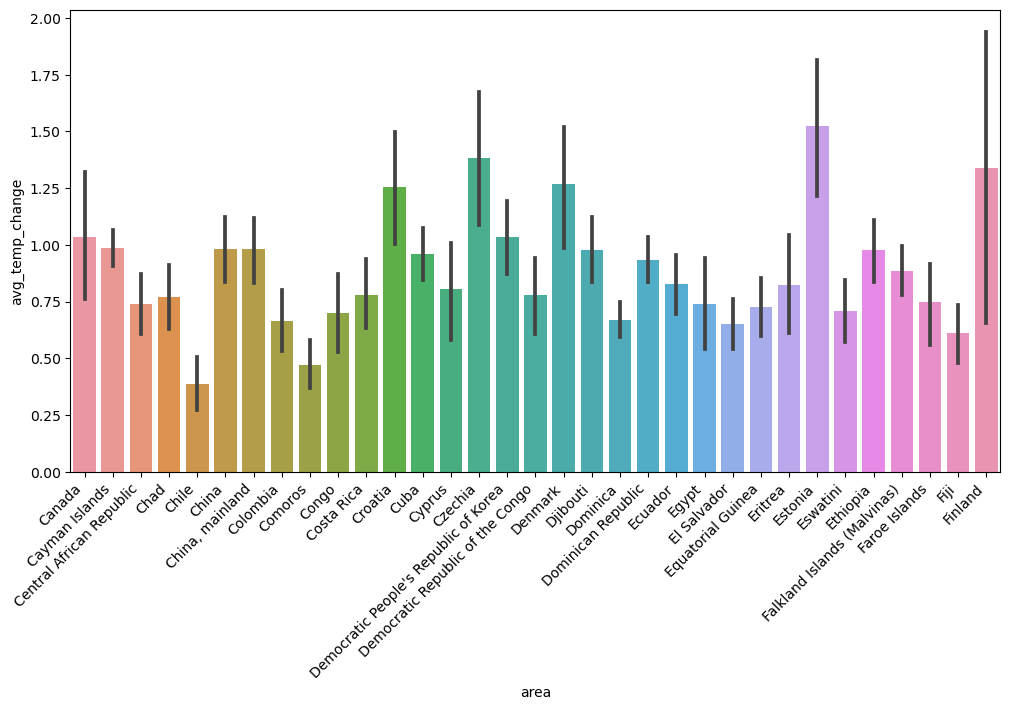

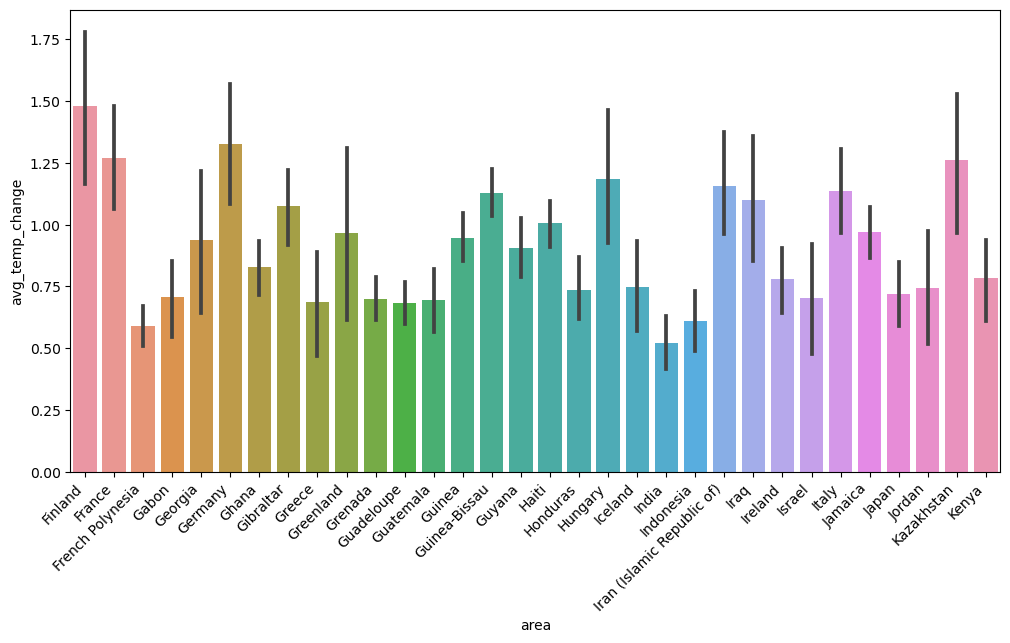

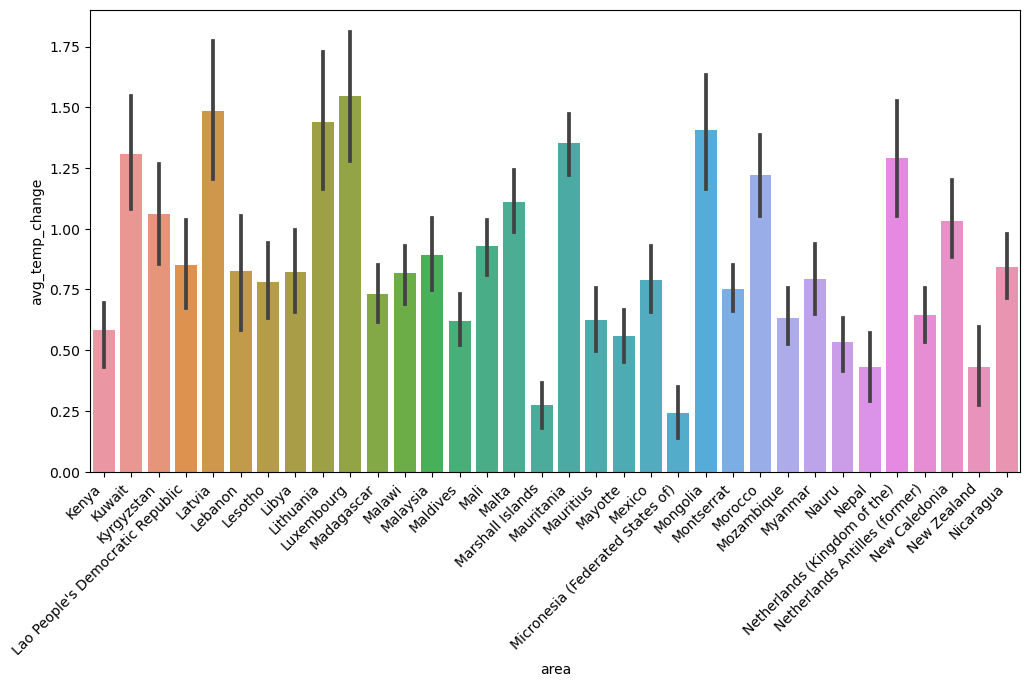

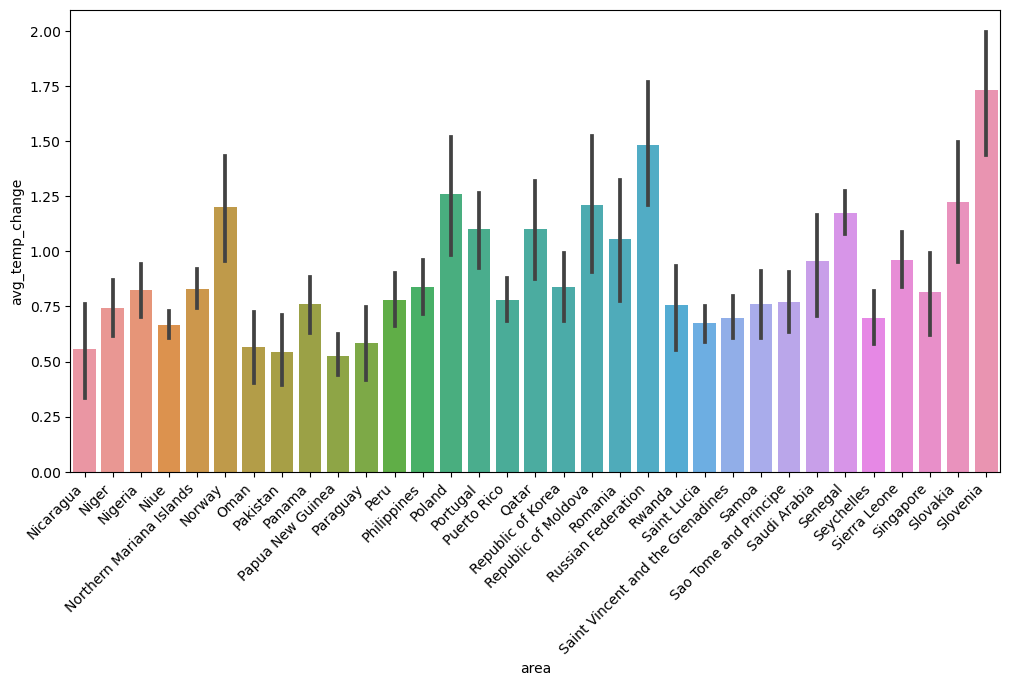

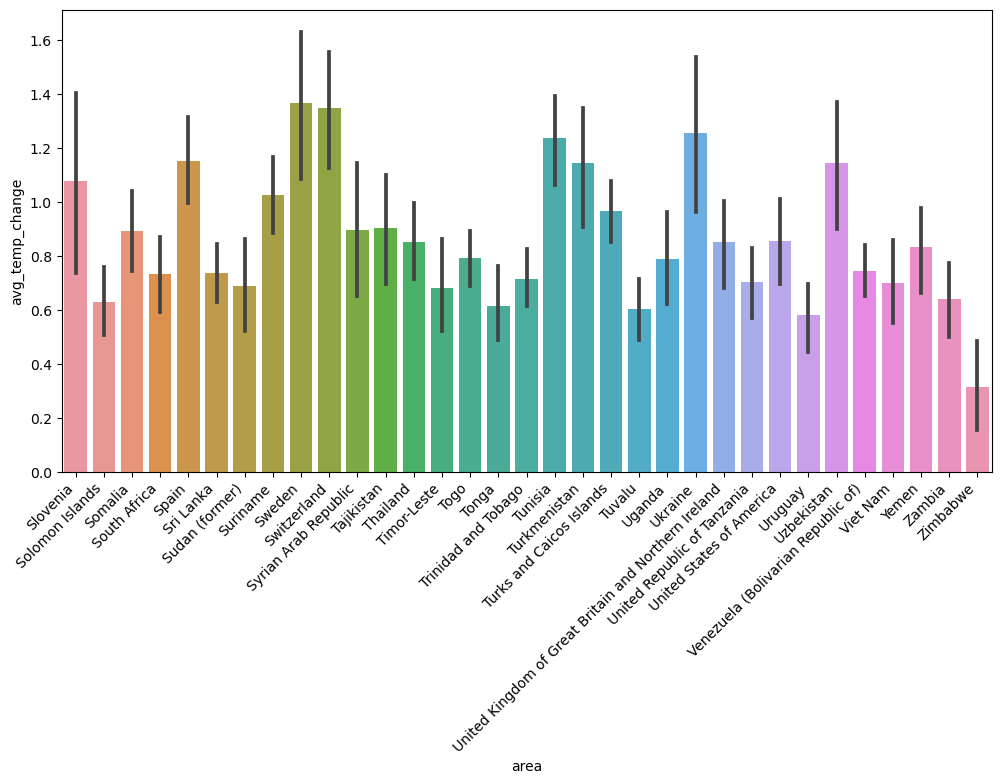

In [22]:
# Categorical features

# due to many values I'm splitting area into 4 groups and plotting the graphs for each of them to visualize the relation to the target
df1_sorted = df1.sort_values(by="area")
group_size = len(df1_sorted) // 6

# creating separate plots for all groups
for i in range(6):
    start = i * group_size
    end = start + group_size
    group = df1_sorted.iloc[start:end]

    if not group.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(x="area", y="avg_temp_change", data=group)
        plt.xticks(rotation=45, ha="right") 
        plt.show()

##### Relationships amongst the features - correlation matrix

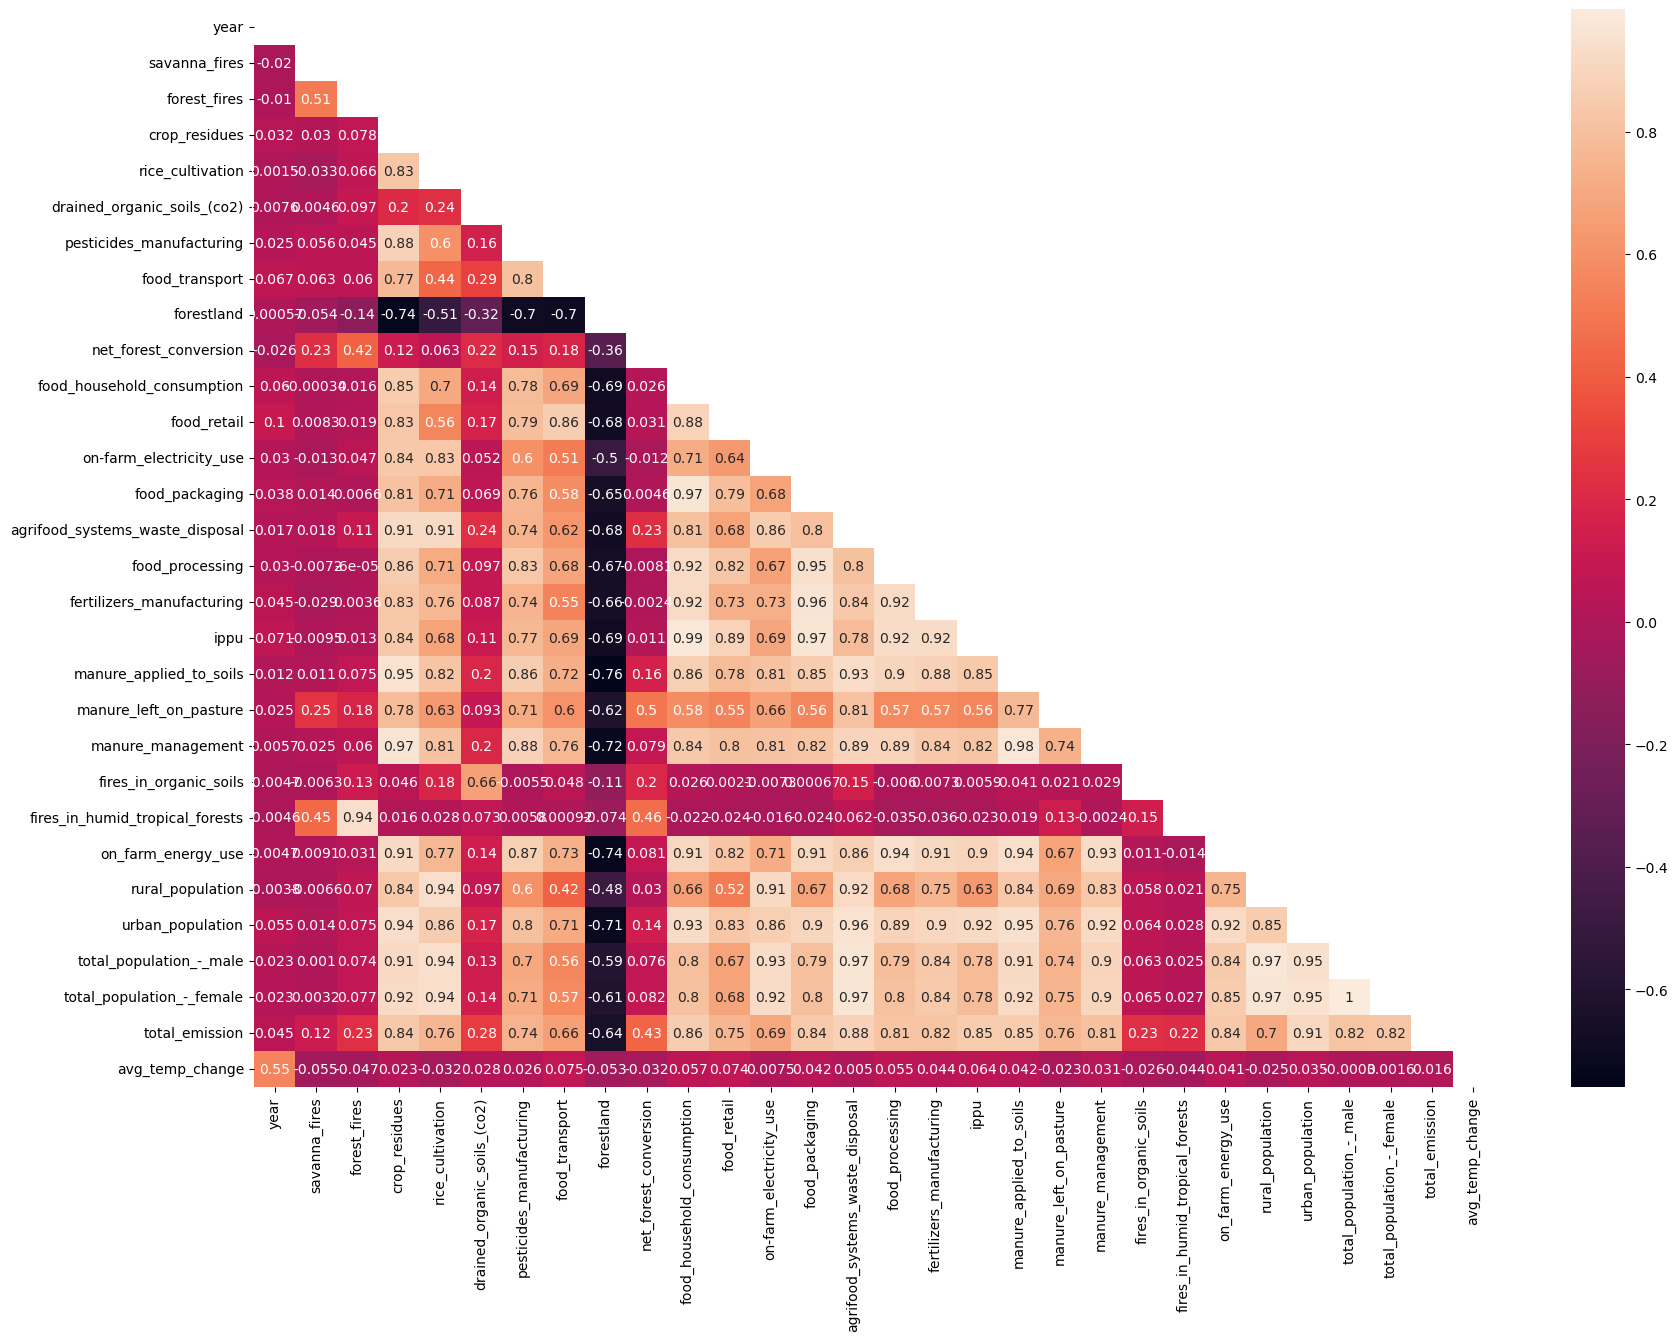

In [23]:
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True 

fig, ax = plt.subplots(figsize=(20, 14))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

# A lot of features is correlated (> 0.9) so it might be necessary for the model to remove some of them 

##### Principal Component Analysis

In [24]:
# In order to reduce the dimensionality of the dataset, I'll use Principal Component Analysis. 
scaler = StandardScaler()
scaled_df = scaler.fit_transform(numericals)
# choosing the number of features to keep
n_components = 5  
pca = PCA(n_components=n_components)
# model fit on the scaled dataset
pca.fit(scaled_df)
top_components = pca.components_[:n_components]
# saving selected features and creating a list of columns to be removed
cols_to_keep = list(numericals.columns[:n_components])
cols_to_keep.insert(0, 'area')
cols_to_keep.append('avg_temp_change')
cols_to_remove = []
for column in df1.columns:
    if column not in cols_to_keep:
        cols_to_remove.append(column)
# creating dataframe with selected columns
df_pca = df1.copy()
df_pca = df_pca.drop(cols_to_remove, axis=1)
df_pca

area  year  savanna_fires  forest_fires  crop_residues  \
0     Afghanistan  1990        14.7237        0.0557       205.6077   
1     Afghanistan  1991        14.7237        0.0557       209.4971   
2     Afghanistan  1992        14.7237        0.0557       196.5341   
3     Afghanistan  1993        14.7237        0.0557       230.8175   
4     Afghanistan  1994        14.7237        0.0557       242.0494   
...           ...   ...            ...           ...            ...   
6960     Zimbabwe  2016      1190.0089      232.5068        70.9451   
6961     Zimbabwe  2017      1431.1407      131.1324       108.6262   
6962     Zimbabwe  2018      1557.5830      221.6222       109.9835   
6963     Zimbabwe  2019      1591.6049      171.0262        45.4574   
6964     Zimbabwe  2020       481.9027       48.4197       108.3022   

      rice_cultivation  avg_temp_change  
0             686.0000         0.536167  
1             678.1600         0.020667  
2             686.0000        -0.259583  
3             686.0000         0.101917  
4             705.6000         0.372250  
...                ...              ...  
6960            7.4088         1.120250  
6961            7.9458         0.046500  
6962            8.1399         0.516333  
6963            7.8322         0.985667  
6964            7.9733         0.189000  

[5873 rows x 7 columns]

##### Relationships amongst the features - Variance Inflation Factor

In [25]:
# Checking multicolinearity between features 
vif = add_constant(numericals)

threshold = 10

while True:
    values = [variance_inflation_factor(np.array(vif), i)
              for i in range(len(vif.columns))][1:]
    display(pd.DataFrame(values, index=vif.columns[1:]).sort_values(0))
    if max(values) > threshold:
        col_index = values.index(max(values)) + 1
        column_name = vif.columns[col_index]
        vif = vif.drop(column_name, axis=1)
    else:
        break
vif

0
avg_temp_change                       1.512625
year                                  1.566647
pesticides_manufacturing             43.647679
fires_in_humid_tropical_forests     165.050624
crop_residues                       215.549232
forest_fires                        219.100079
manure_applied_to_soils             264.799401
savanna_fires                       409.536499
food_transport                      474.782919
manure_management                   960.615553
food_retail                        1097.542465
manure_left_on_pasture             1216.930325
on-farm_electricity_use            1327.574787
on_farm_energy_use                 1875.019474
fertilizers_manufacturing          2006.541505
food_packaging                     2099.686776
urban_population                   2719.341624
drained_organic_soils_(co2)        3713.166499
rural_population                   4106.042997
rice_cultivation                   4625.442791
food_processing                    5903.842896
agrifood_systems_waste_disposal    7451.686339
fires_in_organic_soils             7770.908869
food_household_consumption         9372.738026
total_population_-_male           10492.544301
total_population_-_female         15579.243646
forestland                        92301.320006
net_forest_conversion            143600.092978
ippu                             167702.559205
total_emission                   780483.662001

0
avg_temp_change                      1.510459
year                                 1.566252
savanna_fires                        1.965518
fires_in_organic_soils               2.109063
drained_organic_soils_(co2)          3.120703
net_forest_conversion                4.124562
forestland                           5.797591
pesticides_manufacturing            11.523797
manure_left_on_pasture              11.568842
fires_in_humid_tropical_forests     11.596677
forest_fires                        11.635512
food_transport                      15.456703
on-farm_electricity_use             17.389622
rice_cultivation                    17.452209
food_retail                         23.867012
fertilizers_manufacturing           24.737648
on_farm_energy_use                  25.795873
food_processing                     27.689990
crop_residues                       55.808927
food_household_consumption          67.052030
agrifood_systems_waste_disposal     69.503877
food_packaging                      97.329487
ippu                               110.468459
manure_management                  125.146154
manure_applied_to_soils            140.877415
urban_population                  2717.907858
rural_population                  4101.200372
total_population_-_male          10468.388696
total_population_-_female        15492.483031

0
avg_temp_change                     1.508928
year                                1.564515
savanna_fires                       1.965420
fires_in_organic_soils              2.102780
drained_organic_soils_(co2)         3.063060
net_forest_conversion               3.957228
forestland                          4.695661
pesticides_manufacturing           11.262105
forest_fires                       11.450947
fires_in_humid_tropical_forests    11.563738
manure_left_on_pasture             11.567302
on-farm_electricity_use            14.969435
food_transport                     15.319881
rice_cultivation                   17.373209
food_retail                        23.858085
fertilizers_manufacturing          24.736739
on_farm_energy_use                 25.668885
food_processing                    27.371102
crop_residues                      55.688903
food_household_consumption         66.392047
agrifood_systems_waste_disposal    68.721246
food_packaging                     95.124658
ippu                              105.376094
manure_management                 125.086257
manure_applied_to_soils           140.373347
urban_population                 1576.754628
rural_population                 2674.517830
total_population_-_male          7033.621989

0
avg_temp_change                    1.508849
year                               1.564126
savanna_fires                      1.957099
fires_in_organic_soils             2.098959
drained_organic_soils_(co2)        3.062308
net_forest_conversion              3.913612
forestland                         4.558428
pesticides_manufacturing          11.004507
forest_fires                      11.273452
manure_left_on_pasture            11.372080
fires_in_humid_tropical_forests   11.454121
on-farm_electricity_use           14.057746
food_transport                    15.300169
rice_cultivation                  17.273036
food_retail                       23.848440
on_farm_energy_use                24.039019
fertilizers_manufacturing         24.721765
food_processing                   27.296880
crop_residues                     55.555674
food_household_consumption        66.345526
agrifood_systems_waste_disposal   68.467633
rural_population                  77.587060
food_packaging                    94.783334
ippu                             102.022217
manure_management                123.871600
manure_applied_to_soils          137.862934
urban_population                 224.652722

0
avg_temp_change                   1.508193
year                              1.559206
savanna_fires                     1.957099
fires_in_organic_soils            2.098469
drained_organic_soils_(co2)       3.060918
net_forest_conversion             3.896153
forestland                        4.350850
pesticides_manufacturing         10.786840
manure_left_on_pasture           11.173688
forest_fires                     11.273118
fires_in_humid_tropical_forests  11.449392
food_transport                   12.402389
on-farm_electricity_use          13.346342
rice_cultivation                 17.011231
food_retail                      21.621543
on_farm_energy_use               23.077270
fertilizers_manufacturing        24.589524
food_processing                  26.906173
crop_residues                    55.492567
agrifood_systems_waste_disposal  59.686345
rural_population                 63.648632
food_household_consumption       64.535442
ippu                             82.915407
manure_management                91.851967
food_packaging                   93.979473
manure_applied_to_soils          97.275795

0
avg_temp_change                   1.505239
year                              1.557072
savanna_fires                     1.893297
fires_in_organic_soils            2.055968
drained_organic_soils_(co2)       3.059525
net_forest_conversion             3.858504
forestland                        3.980955
pesticides_manufacturing         10.653406
manure_left_on_pasture           10.730230
forest_fires                     11.253124
fires_in_humid_tropical_forests  11.444952
food_transport                   11.630895
on-farm_electricity_use          12.701835
rice_cultivation                 16.844853
food_retail                      21.216377
on_farm_energy_use               21.754723
fertilizers_manufacturing        24.202591
food_processing                  24.612634
manure_management                34.395075
agrifood_systems_waste_disposal  48.192916
crop_residues                    52.241594
rural_population                 60.468470
food_household_consumption       63.267667
ippu                             82.893349
food_packaging                   90.539893

0
avg_temp_change                   1.505065
year                              1.554535
savanna_fires                     1.812862
fires_in_organic_soils            2.054795
drained_organic_soils_(co2)       3.052090
net_forest_conversion             3.848184
forestland                        3.956372
pesticides_manufacturing          9.777422
manure_left_on_pasture           10.568011
food_transport                   11.015019
forest_fires                     11.248172
fires_in_humid_tropical_forests  11.440373
on-farm_electricity_use          12.570303
rice_cultivation                 16.456828
food_processing                  19.031839
food_retail                      20.294296
on_farm_energy_use               21.446166
fertilizers_manufacturing        22.293923
manure_management                34.254271
agrifood_systems_waste_disposal  47.314222
crop_residues                    47.419107
food_household_consumption       50.766443
rural_population                 59.324682
ippu                             65.554867

0
avg_temp_change                   1.503566
year                              1.552229
savanna_fires                     1.812441
fires_in_organic_soils            2.054759
drained_organic_soils_(co2)       2.923662
net_forest_conversion             3.823515
forestland                        3.956173
pesticides_manufacturing          9.600219
manure_left_on_pasture           10.566388
food_transport                   10.870002
forest_fires                     11.240273
fires_in_humid_tropical_forests  11.439612
on-farm_electricity_use          12.557639
rice_cultivation                 16.315066
fertilizers_manufacturing        16.349452
food_processing                  18.316985
food_retail                      18.456088
on_farm_energy_use               20.811780
food_household_consumption       28.149896
manure_management                33.427899
agrifood_systems_waste_disposal  46.326759
crop_residues                    47.129828
rural_population                 57.843691

0
avg_temp_change                   1.503165
year                              1.552110
savanna_fires                     1.803852
fires_in_organic_soils            2.041389
drained_organic_soils_(co2)       2.809814
net_forest_conversion             3.448161
forestland                        3.882691
on-farm_electricity_use           8.441252
pesticides_manufacturing          9.169723
food_transport                    9.780280
manure_left_on_pasture           10.557795
forest_fires                     11.221809
fires_in_humid_tropical_forests  11.362423
rice_cultivation                 11.972747
fertilizers_manufacturing        16.093024
food_processing                  18.306043
food_retail                      18.451554
on_farm_energy_use               20.512695
food_household_consumption       21.448681
manure_management                31.039916
agrifood_systems_waste_disposal  32.421294
crop_residues                    46.069127

0
avg_temp_change                   1.503017
year                              1.551808
savanna_fires                     1.780518
fires_in_organic_soils            2.039196
drained_organic_soils_(co2)       2.790529
net_forest_conversion             3.379737
forestland                        3.701313
on-farm_electricity_use           7.875457
pesticides_manufacturing          8.095506
manure_left_on_pasture            9.631562
food_transport                    9.712939
rice_cultivation                 10.956286
forest_fires                     11.213155
fires_in_humid_tropical_forests  11.358905
fertilizers_manufacturing        16.046249
food_retail                      16.222675
food_processing                  17.565716
on_farm_energy_use               20.422676
food_household_consumption       21.428971
manure_management                23.226777
agrifood_systems_waste_disposal  32.393142

0
avg_temp_change                   1.502334
year                              1.551737
savanna_fires                     1.665600
fires_in_organic_soils            2.015040
drained_organic_soils_(co2)       2.726391
net_forest_conversion             3.367698
forestland                        3.688408
manure_left_on_pasture            6.784167
on-farm_electricity_use           6.881119
rice_cultivation                  7.159242
pesticides_manufacturing          7.853737
food_transport                    8.856678
forest_fires                     11.181424
fires_in_humid_tropical_forests  11.239056
food_retail                      14.265002
fertilizers_manufacturing        15.678395
food_processing                  17.278224
on_farm_energy_use               20.246391
food_household_consumption       20.450150
manure_management                23.226414

0
avg_temp_change                   1.495538
year                              1.538112
savanna_fires                     1.659787
fires_in_organic_soils            1.974819
drained_organic_soils_(co2)       2.570210
net_forest_conversion             3.234501
forestland                        3.606332
on-farm_electricity_use           5.770523
manure_left_on_pasture            6.518438
pesticides_manufacturing          6.675120
rice_cultivation                  6.721944
food_transport                    8.786493
forest_fires                     11.107538
fires_in_humid_tropical_forests  11.224418
food_retail                      14.186886
food_processing                  15.312588
fertilizers_manufacturing        15.657088
on_farm_energy_use               18.894560
food_household_consumption       19.002982

0
avg_temp_change                   1.494503
year                              1.534146
savanna_fires                     1.658544
fires_in_organic_soils            1.973191
drained_organic_soils_(co2)       2.531411
net_forest_conversion             3.230209
forestland                        3.601497
on-farm_electricity_use           5.766052
manure_left_on_pasture            6.459156
pesticides_manufacturing          6.590564
rice_cultivation                  6.654310
food_retail                       7.812423
food_transport                    8.146840
forest_fires                     11.102303
fires_in_humid_tropical_forests  11.222372
fertilizers_manufacturing        11.849656
food_processing                  15.083765
on_farm_energy_use               18.640642

0
avg_temp_change                   1.482663
year                              1.500186
savanna_fires                     1.658012
fires_in_organic_soils            1.964438
drained_organic_soils_(co2)       2.514671
net_forest_conversion             3.220156
forestland                        3.493568
on-farm_electricity_use           5.585955
rice_cultivation                  5.800499
pesticides_manufacturing          6.290341
manure_left_on_pasture            6.403010
food_transport                    7.671692
food_retail                       7.808065
fertilizers_manufacturing        10.473868
forest_fires                     11.100828
fires_in_humid_tropical_forests  11.219226
food_processing                  13.129727

0
avg_temp_change                   1.469615
year                              1.477534
savanna_fires                     1.653160
fires_in_organic_soils            1.963329
drained_organic_soils_(co2)       2.456280
net_forest_conversion             3.200361
forestland                        3.492615
on-farm_electricity_use           5.217504
rice_cultivation                  5.462640
fertilizers_manufacturing         5.526878
pesticides_manufacturing          5.716024
manure_left_on_pasture            6.373761
food_retail                       7.249550
food_transport                    7.590682
forest_fires                     11.074398
fires_in_humid_tropical_forests  11.190073

0
avg_temp_change              1.469059
year                         1.477481
savanna_fires                1.649240
forest_fires                 1.742469
fires_in_organic_soils       1.946420
drained_organic_soils_(co2)  2.430953
net_forest_conversion        2.847422
forestland                   3.311483
on-farm_electricity_use      5.199484
rice_cultivation             5.436792
fertilizers_manufacturing    5.525446
pesticides_manufacturing     5.633643
manure_left_on_pasture       6.235708
food_retail                  7.149777
food_transport               7.529789

const  year  savanna_fires  forest_fires  rice_cultivation  \
0       1.0  1990        14.7237        0.0557          686.0000   
1       1.0  1991        14.7237        0.0557          678.1600   
2       1.0  1992        14.7237        0.0557          686.0000   
3       1.0  1993        14.7237        0.0557          686.0000   
4       1.0  1994        14.7237        0.0557          705.6000   
...     ...   ...            ...           ...               ...   
6960    1.0  2016      1190.0089      232.5068            7.4088   
6961    1.0  2017      1431.1407      131.1324            7.9458   
6962    1.0  2018      1557.5830      221.6222            8.1399   
6963    1.0  2019      1591.6049      171.0262            7.8322   
6964    1.0  2020       481.9027       48.4197            7.9733   

      drained_organic_soils_(co2)  pesticides_manufacturing  food_transport  \
0                             0.0                 11.807483         63.1152   
1                             0.0                 11.712073         61.2125   
2                             0.0                 11.712073         53.3170   
3                             0.0                 11.712073         54.3617   
4                             0.0                 11.712073         53.9874   
...                           ...                       ...             ...   
6960                          0.0                 75.000000        251.1465   
6961                          0.0                 67.000000        255.7975   
6962                          0.0                 66.000000        327.0897   
6963                          0.0                 73.000000        290.1893   
6964                          0.0                 73.000000        238.7639   

      forestland  net_forest_conversion  food_retail  on-farm_electricity_use  \
0     -2388.8030                 0.0000     109.6446                  14.2666   
1     -2388.8030                 0.0000     116.6789                  11.4182   
2     -2388.8030                 0.0000     126.1721                   9.2752   
3     -2388.8030                 0.0000      81.4607                   9.0635   
4     -2388.8030                 0.0000      90.4008                   8.3962   
...          ...                    ...          ...                      ...   
6960  76500.2982             10662.4408     443.0872                 428.4352   
6961  76500.2982             10662.4408     445.3881                 304.7852   
6962  76500.2982             10662.4408     492.8599                 346.8512   
6963  76500.2982             10662.4408     542.5922                 350.2168   
6964  76500.2982             10662.4408     568.0445                 350.2168   

      fertilizers_manufacturing  manure_left_on_pasture  \
0                     11.997000               1590.5319   
1                     12.853900               1657.2364   
2                     13.492900               1653.5068   
3                     14.055900               1642.9623   
4                     15.126900               1689.3593   
...                         ...                     ...   
6960                2585.080847               2721.1459   
6961                1227.240253               2744.8763   
6962                1127.687805               2790.0949   
6963                2485.528399               2828.7215   
6964                1227.240253               2829.7457   

      fires_in_organic_soils  avg_temp_change  
0                        0.0         0.536167  
1                        0.0         0.020667  
2                        0.0        -0.259583  
3                        0.0         0.101917  
4                        0.0         0.372250  
...                      ...              ...  
6960                     0.0         1.120250  
6961                     0.0         0.046500  
6962                     0.0         0.516333  
6963                     0.0         0.985667  
6964                     0.0  

In [26]:
vif = [col for col in df1.columns if col not in vif] #checking column we might remove according to VIF analysis

In [27]:
cols_to_remove = vif[1:]
cols_to_remove

['crop_residues',
 'food_household_consumption',
 'food_packaging',
 'agrifood_systems_waste_disposal',
 'food_processing',
 'ippu',
 'manure_applied_to_soils',
 'manure_management',
 'fires_in_humid_tropical_forests',
 'on_farm_energy_use',
 'rural_population',
 'urban_population',
 'total_population_-_male',
 'total_population_-_female',
 'total_emission']

In [28]:
df_vif = df1.copy()

In [29]:
df_vif = df_vif.drop(cols_to_remove, axis=1)
df_vif

area  year  savanna_fires  forest_fires  rice_cultivation  \
0     Afghanistan  1990        14.7237        0.0557          686.0000   
1     Afghanistan  1991        14.7237        0.0557          678.1600   
2     Afghanistan  1992        14.7237        0.0557          686.0000   
3     Afghanistan  1993        14.7237        0.0557          686.0000   
4     Afghanistan  1994        14.7237        0.0557          705.6000   
...           ...   ...            ...           ...               ...   
6960     Zimbabwe  2016      1190.0089      232.5068            7.4088   
6961     Zimbabwe  2017      1431.1407      131.1324            7.9458   
6962     Zimbabwe  2018      1557.5830      221.6222            8.1399   
6963     Zimbabwe  2019      1591.6049      171.0262            7.8322   
6964     Zimbabwe  2020       481.9027       48.4197            7.9733   

      drained_organic_soils_(co2)  pesticides_manufacturing  food_transport  \
0                             0.0                 11.807483         63.1152   
1                             0.0                 11.712073         61.2125   
2                             0.0                 11.712073         53.3170   
3                             0.0                 11.712073         54.3617   
4                             0.0                 11.712073         53.9874   
...                           ...                       ...             ...   
6960                          0.0                 75.000000        251.1465   
6961                          0.0                 67.000000        255.7975   
6962                          0.0                 66.000000        327.0897   
6963                          0.0                 73.000000        290.1893   
6964                          0.0                 73.000000        238.7639   

      forestland  net_forest_conversion  food_retail  on-farm_electricity_use  \
0     -2388.8030                 0.0000     109.6446                  14.2666   
1     -2388.8030                 0.0000     116.6789                  11.4182   
2     -2388.8030                 0.0000     126.1721                   9.2752   
3     -2388.8030                 0.0000      81.4607                   9.0635   
4     -2388.8030                 0.0000      90.4008                   8.3962   
...          ...                    ...          ...                      ...   
6960  76500.2982             10662.4408     443.0872                 428.4352   
6961  76500.2982             10662.4408     445.3881                 304.7852   
6962  76500.2982             10662.4408     492.8599                 346.8512   
6963  76500.2982             10662.4408     542.5922                 350.2168   
6964  76500.2982             10662.4408     568.0445                 350.2168   

      fertilizers_manufacturing  manure_left_on_pasture  \
0                     11.997000               1590.5319   
1                     12.853900               1657.2364   
2                     13.492900               1653.5068   
3                     14.055900               1642.9623   
4                     15.126900               1689.3593   
...                         ...                     ...   
6960                2585.080847               2721.1459   
6961                1227.240253               2744.8763   
6962                1127.687805               2790.0949   
6963                2485.528399               2828.7215   
6964                1227.240253               2829.7457   

      fires_in_organic_soils  avg_temp_change  
0                        0.0         0.536167  
1                        0.0         0.020667  
2                        0.0        -0.259583  
3                        0.0         0.101917  
4                        0.0         0.372250  
...                      ...              ...  
6960                     0.0         1.120250  
6961                     0.0         0.046500  
6962                     0.0         0.516333  
6963         

### Encoding categoricals

In [30]:
df_vif = pd.get_dummies(df_vif, drop_first=True)

In [31]:
df_pca = pd.get_dummies(df_pca, drop_first=True)

In [32]:
df_area_selection = pd.get_dummies(df_area_selection, drop_first=True)

### Regression models

In [33]:
def model_train_test (models, X, y):
    # spliting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # scaling the data using Standard scaler
    scaler= StandardScaler()
    # train-test
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    print("Model\tR2_score\tRMSE_score\tMAE")
    for model in models:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        r2 = round(r2_score(y_test, pred), 2)
        rmse = round(mean_squared_error(y_test, pred), 2)
        mae = round(mean_absolute_error(y_test, pred), 2)
        print(f"{model.__class__.__name__}\t{r2}\t{rmse}\t{mae}")

In [34]:
def model_train_test(models, X, y):
    # train-test split and scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    print("Model\tR2_score\tRMSE_score\tMAE")
    
    # looping through the list of models to check their scores and create plots
    for model in models:
        # fitting the model and getting scores
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        r2 = round(r2_score(y_test, pred), 2)
        rmse = round(mean_squared_error(y_test, pred), 2)
        mae = round(mean_absolute_error(y_test, pred), 2)
        print(f"{model.__class__.__name__}\t{r2}\t{rmse}\t{mae}")
    
    # looping through the list of models to create plots with predictions
    for model in models:
        pred = model.predict(X_test)
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(y_test, pred)
        ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='k')
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predictions')
        ax.set_title(f'{model.__class__.__name__} Predictions vs. True Values')
        plt.show()

In [35]:
lm = LinearRegression()
knn = KNeighborsRegressor()
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()
br = BaggingRegressor()

Model	R2_score	RMSE_score	MAE
LinearRegression	0.5	0.16	0.3
KNeighborsRegressor	0.47	0.17	0.31
RandomForestRegressor	0.6	0.13	0.27
GradientBoostingRegressor	0.5	0.16	0.3
BaggingRegressor	0.58	0.14	0.28


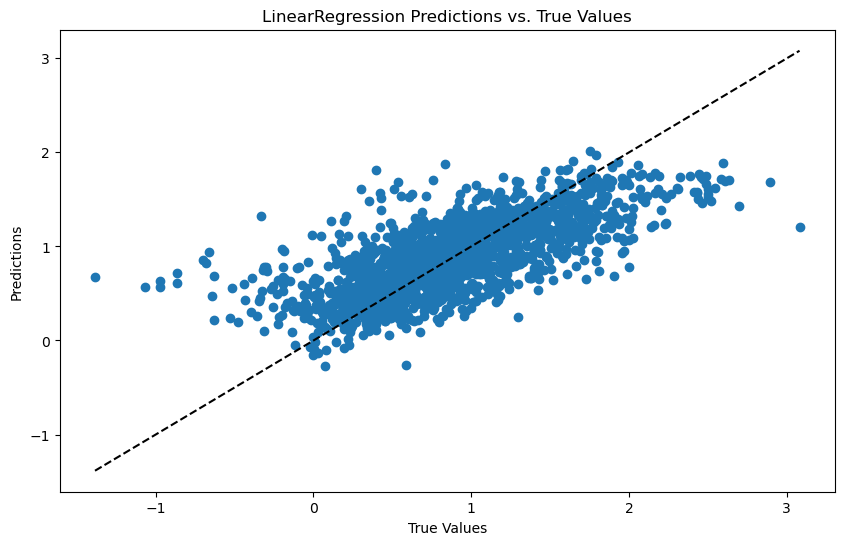

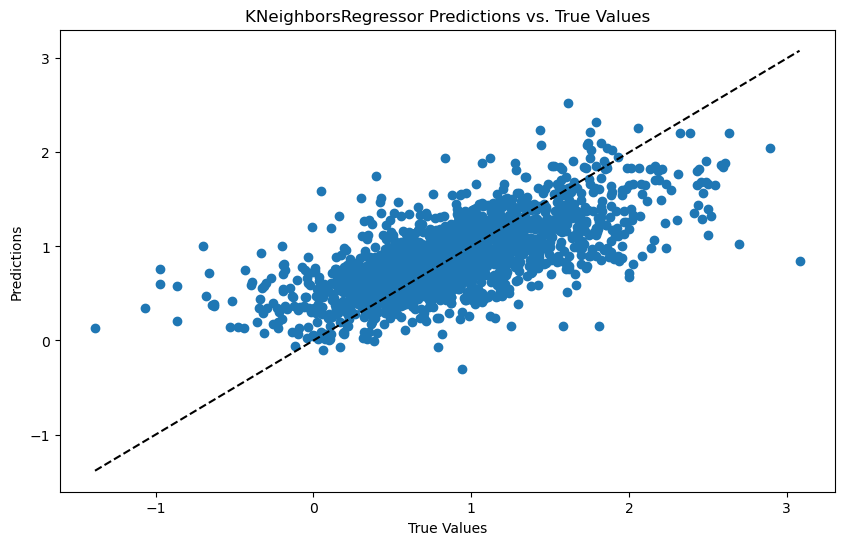

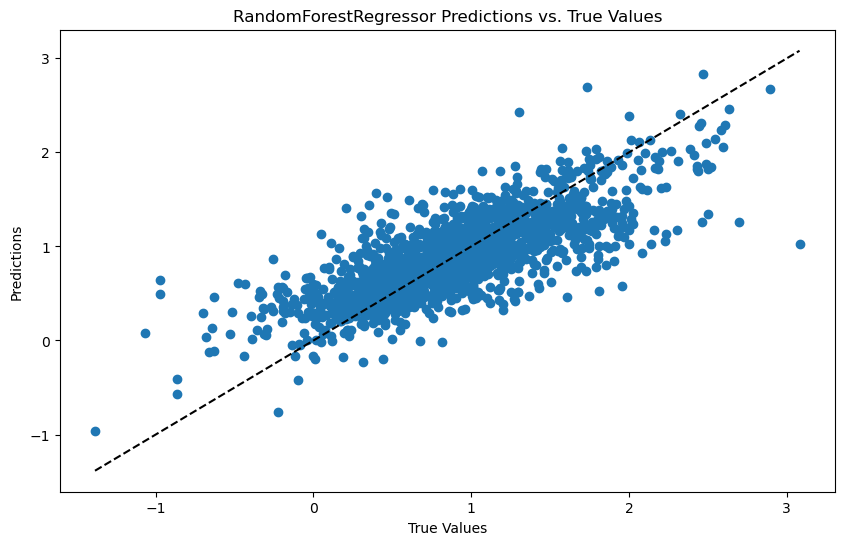

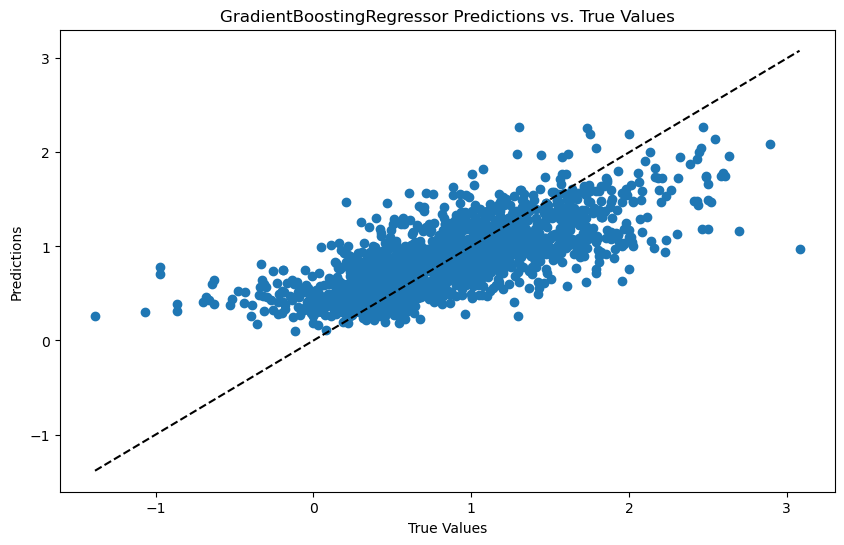

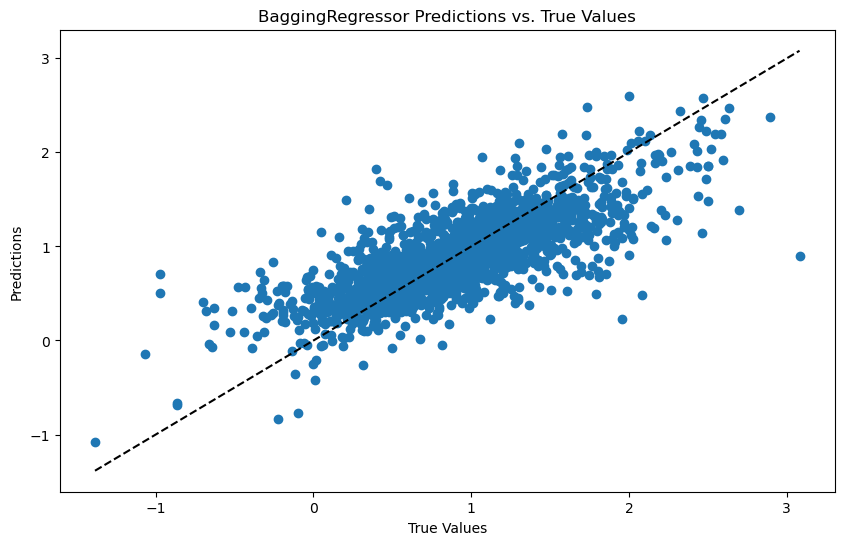

In [36]:
#Checking models on dataset with features selected using VIF
models = [lm, knn, rfr, gbr, br]

X = df_vif.drop(['avg_temp_change'], axis=1)
y = df_vif['avg_temp_change']

model_train_test (models, X, y)

Model	R2_score	RMSE_score	MAE
LinearRegression	0.5	0.16	0.3
KNeighborsRegressor	0.48	0.17	0.3
RandomForestRegressor	0.57	0.14	0.28
GradientBoostingRegressor	0.47	0.17	0.31
BaggingRegressor	0.54	0.15	0.29


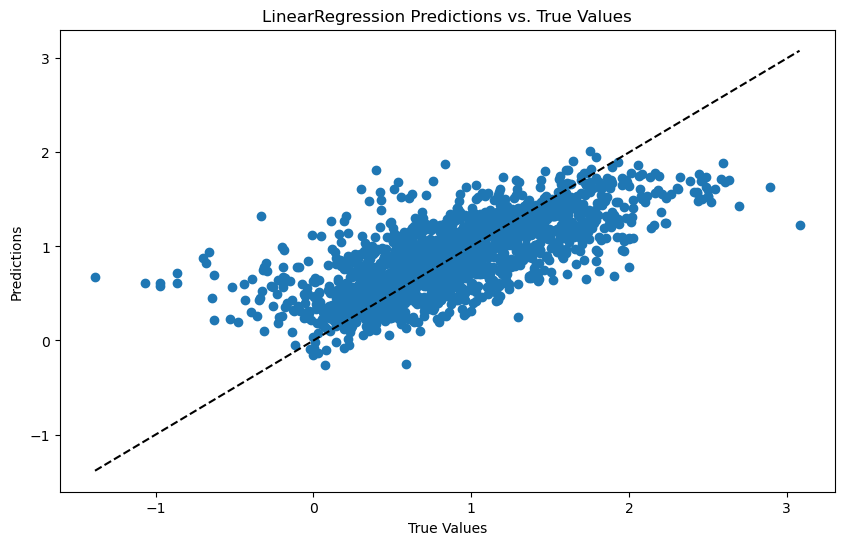

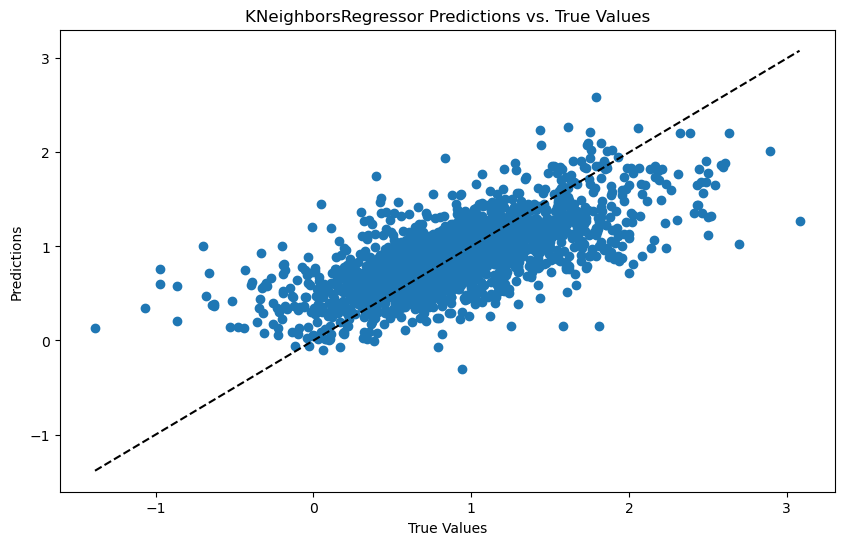

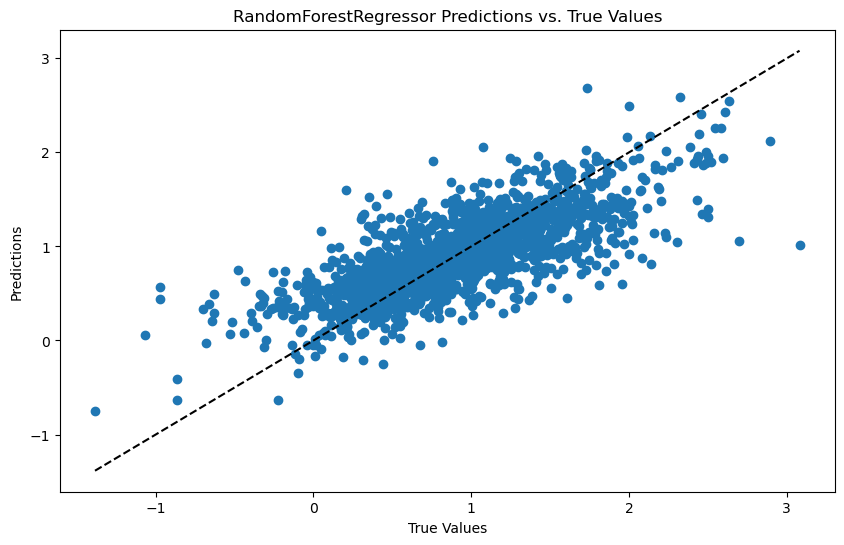

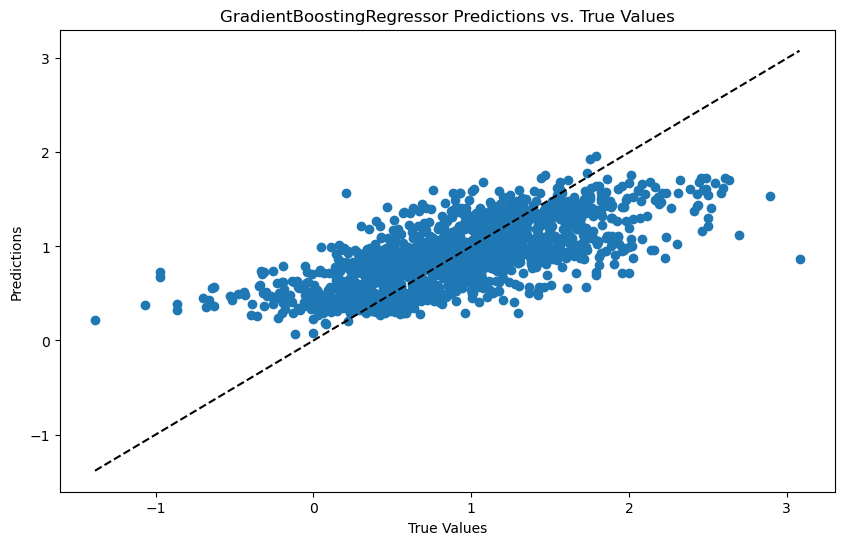

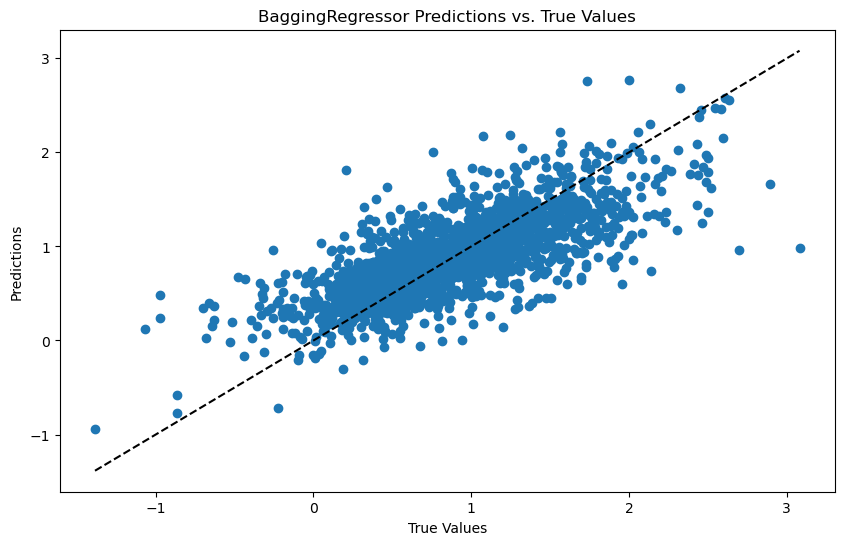

In [37]:
#Checking models on dataset with features selected using PCA
models = [lm, knn, rfr, gbr, br]

X = df_pca.drop(['avg_temp_change'], axis=1)
y = df_pca['avg_temp_change']

model_train_test (models, X, y)

Model	R2_score	RMSE_score	MAE
LinearRegression	0.34	0.1	0.26
KNeighborsRegressor	0.5	0.08	0.21
RandomForestRegressor	0.55	0.07	0.2
GradientBoostingRegressor	0.58	0.07	0.2
BaggingRegressor	0.53	0.07	0.21


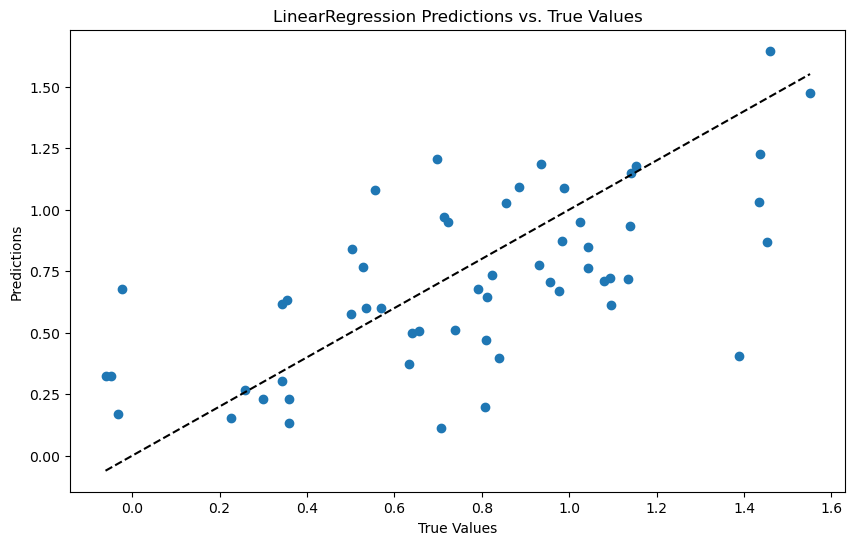

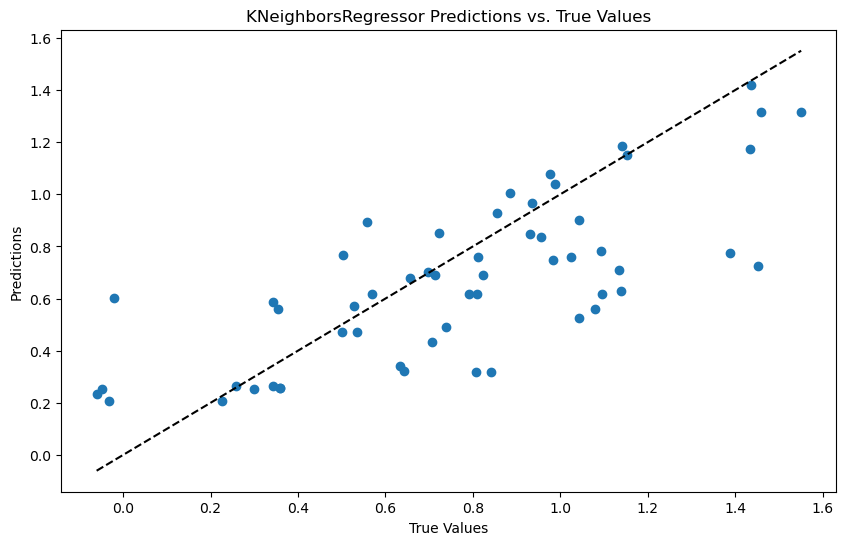

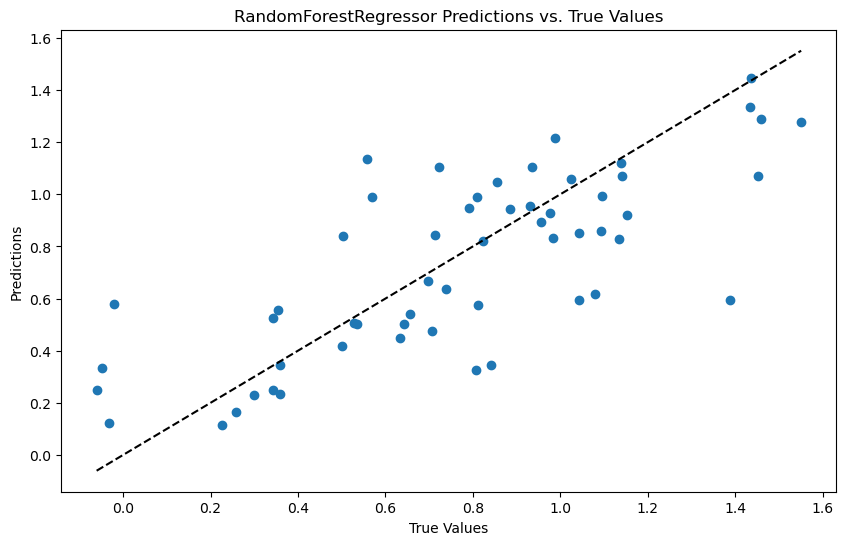

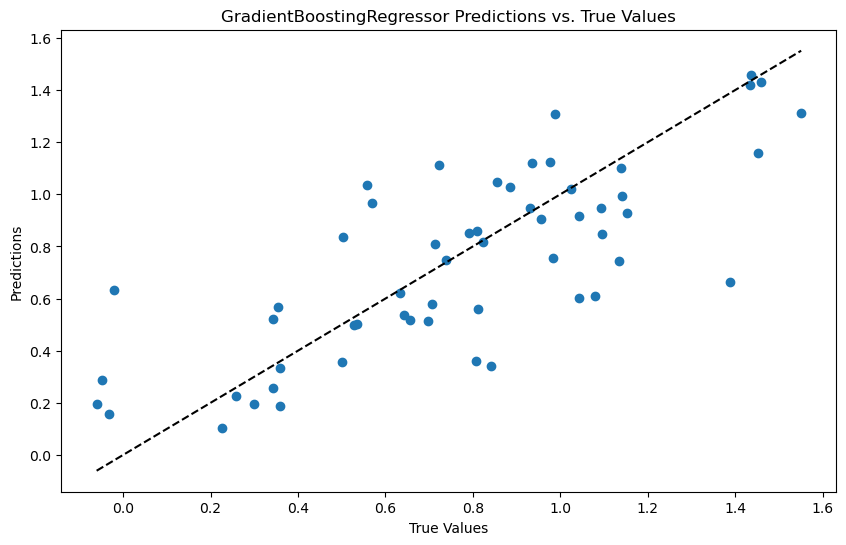

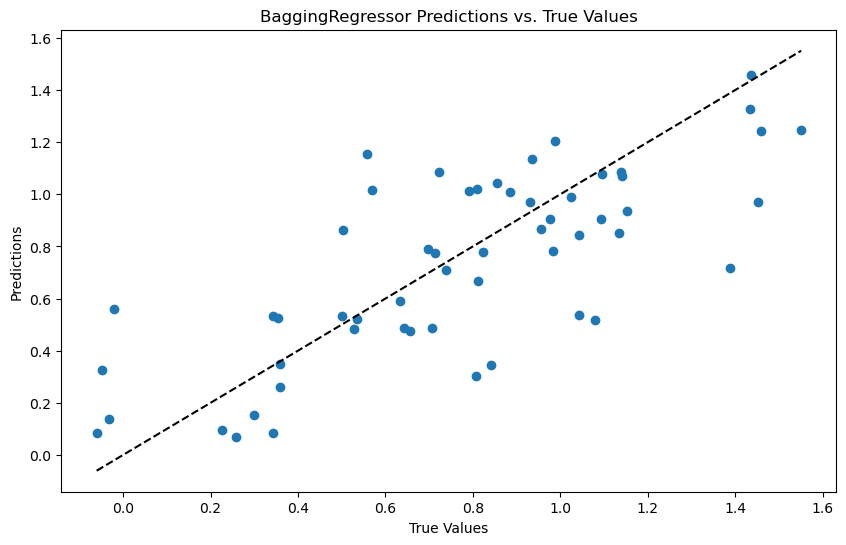

In [38]:
# Checking models on dataset with only 6 selected countries
models = [lm, knn, rfr, gbr, br]

X = df_area_selection.drop(['avg_temp_change'], axis=1)
y = df_area_selection['avg_temp_change']

model_train_test (models, X, y)

Amongst all the models tested on different variants of the dataset, the best result was achieved by RandomForestRegressor using dataset with features selected using VIF analysis. 
Achieved scores are correct (R2: 0.6, RMSE: 0.13, MAE: 0.27) but I will try to improve them using Parameter Hypertuning. 

### RandomForestRegressor - Parameter hypertuning

In [39]:
# Creating the function to test different parameters
def model_hypertune(models, X, y, param_grid=None, cv=5):
    # train-test split and scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    print("Model\tR2_score\tRMSE_score\tMAE")
    
    best_model = None
    best_score = -float('inf')
    best_params = None
    
    for model in models:
        if param_grid:
            # Grid Search with Cross-Validation
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')
            grid_search.fit(X_train, y_train)
            best_model_candidate = grid_search.best_estimator_
            best_params_candidate = grid_search.best_params_
        else:
            best_model_candidate = model
            best_params_candidate = None
        
        # Fitting the best model
        best_model_candidate.fit(X_train, y_train)
        pred = best_model_candidate.predict(X_test)
        r2 = round(r2_score(y_test, pred), 2)
        rmse = round(mean_squared_error(y_test, pred), 2)
        mae = round(mean_absolute_error(y_test, pred), 2)
        
        if r2 > best_score:
            best_score = r2
            best_model = best_model_candidate
            best_params = best_params_candidate
        
        print(f"{best_model_candidate.__class__.__name__}\t{r2}\t{rmse}\t{mae}")
    
        # Creating the scatter plot with predictions
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(y_test, pred)
        ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='k')
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predictions')
        ax.set_title(f'{best_model_candidate.__class__.__name__} Predictions vs. True Values')
        plt.show()
        
    # Returning the best model with its parameters and the score
    return best_model, best_score, best_params

Model	R2_score	RMSE_score	MAE
RandomForestRegressor	0.56	0.07	0.2


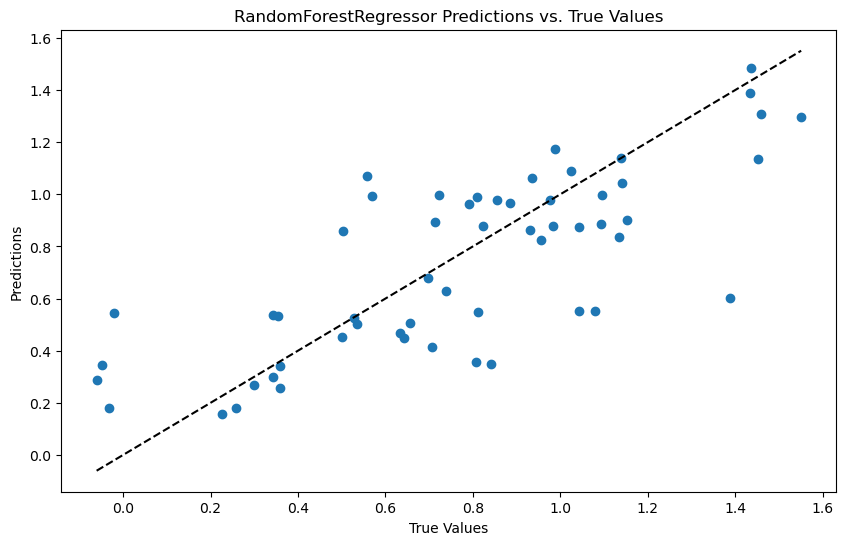

Best Model: RandomForestRegressor
Best R2 Score: 0.56
Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [52]:
# Checking different parameters for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 3, 5]
}
models = [rfr]

best_model, best_score, best_params = model_hypertune(models, X, y, param_grid)

print("Best Model:", best_model.__class__.__name__)
print("Best R2 Score:", best_score)
print("Best Hyperparameters:", best_params)


Benchmark results: R2: 0.6, RMSE: 0.13, MAE: 0.27
Results after hypertuning: R2: 0.56, RMSE: 0.07, MAE: 0.2
After hyperparameters tuning the model's R2 score is slightly lower (it fits the data a bit less) but RMSE and MAE decreased (model's predictions are closed to the actual values). 

### Time series model - Prophet

In [41]:
# creating a function to adjust the dataset to the requirements of Prophet model and remove the last 5 years from the dataset
def train_for_prophet (df,years_to_remove=5):
    #changing dtype to datetime
    df['year'] = pd.to_datetime(df['year'], format='%Y', errors='coerce') 
    # keeping 2 columns (one with datestamp, the second one with the data to predict)
    cols_to_keep = ['year', 'avg_temp_change'] 
    df = df[cols_to_keep]
    # renaming columns to match the naming required by Prophet (dt for datestamp and y)
    df.rename(columns={'year': 'ds'}, inplace=True) 
    df.rename(columns={'avg_temp_change': 'y'}, inplace=True) 
    # saving dataset with last 5 years to be used as a test values
    df_test = df.iloc[-years_to_remove:]
    # removing the last years from the training dataset
    df = df.iloc[:-years_to_remove]
    return df

In [42]:
def test_for_prophet (df):
    #changing dtype to datetime
    df['year'] = pd.to_datetime(df['year'], format='%Y', errors='coerce') 
    # keeping 2 columns (one with datestamp, the second one with the data to predict)
    cols_to_keep = ['year', 'avg_temp_change'] 
    df = df[cols_to_keep]
    # renaming columns to match the naming required by Prophet (dt for datestamp and y)
    df.rename(columns={'year': 'ds'}, inplace=True) 
    df.rename(columns={'avg_temp_change': 'y'}, inplace=True) 
    df_test = df
    return df_test

In [43]:
def prophet_model(df, df_test):
    # fitting the model with df
    proph = Prophet()
    proph.fit(df)
    # creating predictions
    future = proph.make_future_dataframe(freq='A', periods=5)
    forecast = proph.predict(future)
    # creating a subplot
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # adding the actual data from df_test
    fig.add_trace(
        go.Scatter(x=df_test['ds'], y=df_test['y'], name="Actual Targets"),
        secondary_y=False,
    )
    # Adding the predicted values
    fig.add_trace(
        go.Scatter(x=forecast['ds'], y=forecast['yhat'], name="Predicted Targets"),
        secondary_y=True,
    )
    # updating layout and axis labels
    fig.update_layout(
        title_text="Actual vs Predicted Targets",
    )
    fig.update_xaxes(title_text="Timeline")
    fig.update_yaxes(title_text="Actual Targets", secondary_y=False)
    fig.update_yaxes(title_text="Predicted Targets", secondary_y=True)
    # showing the plot
    fig.show()

##### Focus: China

In [44]:
# creating a dataset with China filtered with the last 5 years remove
df_china_train = df1[df1['area'] == 'China'].copy()
df_china_train = train_for_prophet (df_china_train,years_to_remove=5)
# creating a dataset with China filtered with the entire timeline - to be used as a comparison to test
df_china_test = df1[df1['area'] == 'China'].copy()
df_china_test = test_for_prophet (df_china_test)

In [45]:
prophet_model(df_china_train, df_china_test)

19:43:19 - cmdstanpy - INFO - Chain [1] start processing
19:43:19 - cmdstanpy - INFO - Chain [1] done processing


##### Focus: Brazil

In [46]:
# creating a dataset with Brazil filtered with the last 5 years remove
df_brazil_train = df1[df1['area'] == 'Brazil'].copy()
df_brazil_train = train_for_prophet (df_brazil_train,years_to_remove=5)
# creating a dataset with Brazil filtered with the entire timeline - to be used as a comparison to test
df_brazil_test = df1[df1['area'] == 'Brazil'].copy()
df_brazil_test = test_for_prophet (df_brazil_test)

In [47]:
prophet_model(df_brazil_train, df_brazil_test)

19:43:20 - cmdstanpy - INFO - Chain [1] start processing
19:43:20 - cmdstanpy - INFO - Chain [1] done processing


##### Focus: USA

In [48]:
# creating a dataset with USA filtered with the last 5 years remove
df_usa_train = df1[df1['area'] == 'United States of America'].copy()
df_usa_train = train_for_prophet (df_usa_train,years_to_remove=5)
# creating a dataset with USA filtered with the entire timeline - to be used as a comparison to test
df_usa_test = df1[df1['area'] == 'United States of America'].copy()
df_usa_test = test_for_prophet (df_usa_test)

In [49]:
prophet_model(df_usa_train, df_usa_test)

19:43:20 - cmdstanpy - INFO - Chain [1] start processing
19:43:20 - cmdstanpy - INFO - Chain [1] done processing


For none of the 3 tested countries the predictions were very accurate as the model misundertood the trend. It could be interesting to compare it to the CO2 emission estimations as well as hypertune the parameters. Nevertheless it is possible that due to the fact that the dataset contains yearly values and isn't impacted by factors such as holidays or seasonality, Prophet model might not be the right fit for this dataset. Another time series forecasting model (such as ARIMA which doesn't include seasonality) could work better. 